In [1]:
import sys, os, time, shutil, random
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from scipy import misc, signal
# import torch
# from torch.nn import functional as F

from sklearn.neighbors import NearestNeighbors
import networkx as nx
import cv2
import random
import ctypes
from scipy.signal import convolve2d, correlate2d
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter
import io

from omnibelt import load_yaml, save_yaml, multi_index

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import *
from skimage.segmentation import watershed, expand_labels
from skimage.morphology import closing, square, dilation
from skimage.color import label2rgb
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
def showx(im, cover=None):
    plt.figure(figsize=(14,6))
    try:
        plt.imshow(im.astype(int))
        if cover is not None:
            plt.imshow(cover%1000, alpha=0., zorder=10)
    except ValueError:
        plt.imshow(im)
    
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)

def highlight(rgb, mask, opacity=0.2):
    alpha = np.zeros_like(mask).astype(np.uint8)
    
    img = rgb.astype(np.uint8)
    
    alpha[mask!=0] = 255
    alpha[mask==0] = int(255*opacity)
    
    H,W,C = img.shape
    
    if C == 4:
        img[...,-1] = alpha
    else:
        img = np.concatenate([img, alpha.reshape(H,W,1)],-1)
    return showx(img)
    
def show(im):
    return Image.fromarray(im)

def show_region(base, region, rad=500):
#     region = regions[ind]
    y1, x1, y2, x2 = region.bbox
    x, y = x1, y1
    h = y2 - y1
    w = x2 - x1
    cy, cx = region.centroid

    showx(base)

    r = rad
    if h < r:
        h = r
        y = cy - r / 2
    if w < r:
        w = r
        x = cx - r / 2

    plt.xlim(x, x + w)
    plt.ylim(y + h, y)

In [4]:
root = Path('extra/wd/step1')

# mono_path = root / 'wd_mono.png'
color_path = root / 'wd_color.png'

<IPython.core.display.Javascript object>


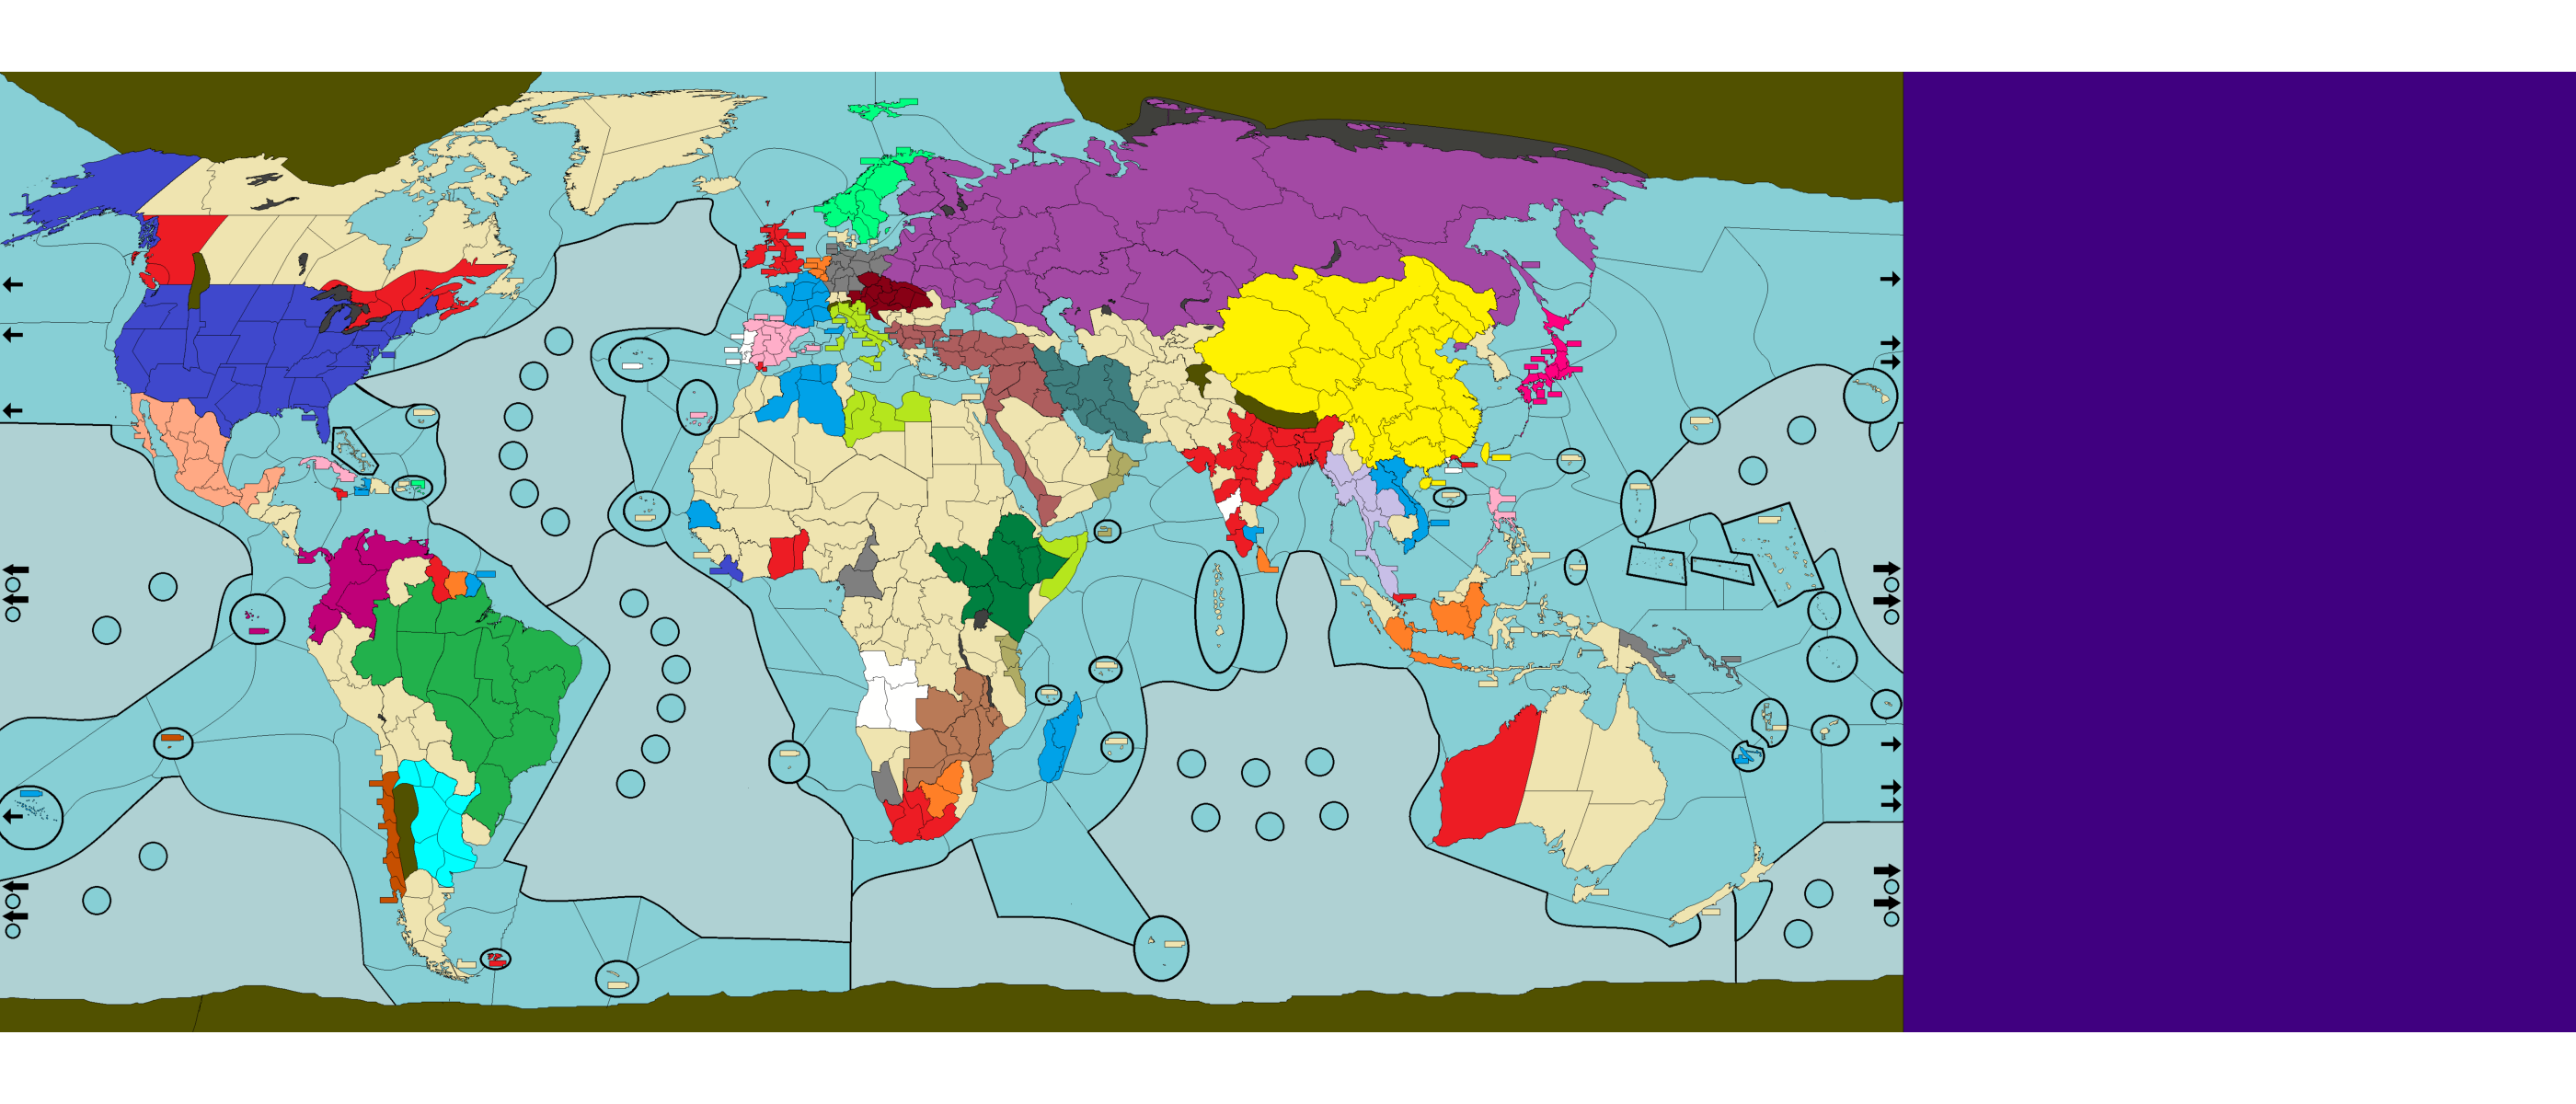

In [5]:
im = Image.open(color_path).convert('RGBA')
im = np.asarray(im)
# show(im)
showx(im[...,:3])

In [13]:
bds = (im[...,:3]<3).astype(int).sum(-1)==3
# showx(bds)

# Filling in Missing Boundaries

In [14]:
def old_fill_diagonals(img):
    H, W = img.shape
    kernel = np.array([[0,1,0,1,0],
                   [1,1,1,1,1],
                   [0,1,1,1,0],
                   [1,1,1,1,1],
                   [0,1,0,1,0]])
    out = F.conv_transpose2d(torch.from_numpy(img).view(1,1,H, W).float(), torch.from_numpy(kernel).view(1,1,5,5).float(), stride=3, padding=1).int().squeeze().numpy().astype(bool).astype(int)
    out -= 1
    out = out.astype(bool).astype(int)
    return out

def fill_diagonals(img):
    H, W = img.shape
    kernel = np.array([[0,1,0,1,0],
                   [1,1,1,1,1],
                   [0,1,1,1,0],
                   [1,1,1,1,1],
                   [0,1,0,1,0]])
    out = cov_transpose(img, kernel, stride=3, padding=1)
    out = np.logical_not(out)
    out = out.astype(bool).astype(int)
    return out
	
	
def cov_transpose(img, kernel, stride, padding):
    # Ensure type is bool
    img = img.astype('bool')
    kernel = kernel.astype('bool')
    
    # Extension
    out = np.repeat(img, stride, axis=0) # Duplicate rows
    out = np.repeat(out, stride, axis=1) # Duplicate columns

    # Padding
    out = np.pad(out, (padding, padding), 'constant', constant_values=(0, 0))
    
    # Window
    view = np.lib.stride_tricks.sliding_window_view(out, window_shape=kernel.shape, writeable=True) # stride = 1 by default
    view = view[::stride, ::stride]
    
    # Mask - only apply pattern if center == 1
    middle = int(np.floor(kernel.shape[0] / 2)) # center of kernel
    mask = view[:, :, middle, middle] == 1
    
    # Apply kernel
    view[mask] = view[mask] | kernel
    
    # Cut off padding
    out = out[1:-1, 1:-1]
    
    return out

In [15]:
sep = im[...,:3].copy().astype(int)
vdiff = sep[1:] - sep[:-1]
hdiff = sep[:,1:] - sep[:,:-1]
vdiff = np.abs(vdiff).sum(-1).astype(bool)#.astype(int)
hdiff = np.abs(hdiff).sum(-1).astype(bool)#.astype(int)
vdiff.shape, hdiff.shape

((2231, 5988), (2232, 5987))

In [16]:
bds = sep.sum(-1)==0
vdiff[bds[1:]] = 0
vdiff[bds[:-1]] = 0
hdiff[bds[:,1:]] = 0
hdiff[bds[:,:-1]] = 0

In [17]:
sep[1:][vdiff] = 0
sep[:-1][vdiff] = 0
sep[:,1:][hdiff] = 0
sep[:,:-1][hdiff] = 0

In [18]:
white = np.abs(sep - 255).sum(-1)==0
# showx(white)
white.sum()

339

In [19]:
sep[white] = 0
# showx(sep)

# Filling in Diagonals

In [20]:
# bds = im[...,:3].sum(-1)==0
bds = sep.sum(-1)==0
bds.shape

(2232, 5988)

In [21]:
strt = fill_diagonals(bds)
strt.shape

(6696, 17964)

In [22]:
# showx(strt)

In [23]:
slbls = label(strt)[1::3, 1::3]
# showx(slbls)
slbls.shape, slbls.max()

((2232, 5988), 1810)

In [24]:
def showx(im, cover=slbls):
    plt.figure(figsize=(20,10))
    try:
        plt.imshow(im.astype(int))
        if cover is not None:
            plt.imshow(cover%1000, alpha=0., zorder=10)
    except ValueError:
        plt.imshow(im)
    
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)


In [25]:
# showx(slbls)

# Identify Labels

In [26]:
labels_path = root / 'wd_labels.png'
names = None

In [27]:
lm = Image.open(labels_path).convert('RGBA')
lm = np.asarray(lm)
# show(lm)

In [28]:
boxes = lm[...,-1].astype(bool)
blbls = label(boxes)
# showx(blbls)

In [29]:
# showx(blbls==641)

In [30]:
blbls.max()

749

In [31]:
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax+1, cmin, cmax+1

In [32]:
# rmin, rmax, cmin, cmax = bbox2(blbls==np.random.randint(blbls.max()))
# name = 255 - lm[rmin:rmax, cmin:cmax,:3]
# H, W = name.shape[:2]
# show(name)

In [33]:
import pytesseract
# os.environ['PATH'] += ';C:\\Users\\anwan\\AppData\\Local\\Programs\\Tesseract-OCR'

ModuleNotFoundError: No module named 'pytesseract'

In [ ]:
lblnames = []
scale = 2
# img = cv2.resize(name, (10*W, 10*H), interpolation=cv2.INTER_NEAREST )
# img = cv2.resize(name, (10*W, 10*H), interpolation=cv2.INTER_LANCZOS4)

itr = tqdm(range(1,blbls.max()+1))
for idx in itr:
    rmin, rmax, cmin, cmax = bbox2(blbls==idx)
    name = 255 - lm[rmin:rmax, cmin:cmax,:3]
    H, W = name.shape[:2]
    img = cv2.resize(name, (scale*W, scale*H), interpolation=cv2.INTER_CUBIC)
    
    base = np.ones((120,120,3)).astype(int)*255
    offset = 20
    base[offset:offset+img.shape[0],offset:offset+img.shape[1]] = img

    base = base.mean(-1).astype(np.uint8)
    txt = pytesseract.image_to_string(show(base), lang='eng')
    lblnames.append(txt)
    itr.set_description(txt)
len(lblnames)

In [27]:
names = lblnames.copy()
names = [name.strip().replace('\n', '') for name in names]
guesses = names.copy()
names[:5]

['SVAL', 'EGRE', 'BARE', 'JANM', 'LOFO']

In [28]:
len([n for n in names if len(n)]) / len(names)

0.9444444444444444

In [34]:
def _get_label_pixels(idx, scale=4):
    rmin, rmax, cmin, cmax = bbox2(blbls==idx+1)
    name = 255 - lm[rmin:rmax, cmin:cmax,:3]
    H, W = name.shape[:2]
    img = cv2.resize(name, (scale*W, scale*H), interpolation=cv2.INTER_CUBIC)
    return img

def compress_to_bytes(data, fmt):
    """
    Helper function to compress image data via PIL/Pillow.
    """
    buff = io.BytesIO()
    img = Image.fromarray(data)    
    img.save(buff, format=fmt)
    
    return buff.getvalue()

In [35]:
# show(_get_label_pixels(500))

In [36]:
fixed = [None]*blbls.max()

In [37]:
guesses = names.copy() if names is not None else None

todo = iter(tqdm([i for i,n in enumerate(fixed) if n is None]))
prompt = widgets.Label()
displblimg = widgets.Image()
textbox = widgets.Text()
response = widgets.Label()

def _update_display():
    try:
        current = next(todo)
    except StopIteration:
        clear_output()
        print('Done!')
    else:
        prompt.index = current
        prompt.value = f'fixed[{current}] = '
        displblimg.value = compress_to_bytes(_get_label_pixels(current),fmt='png')
        textbox.value = guesses[current] if guesses is not None else ''

def _on_submit_func(sender):
    idx = prompt.index
    fixed[idx] = textbox.value
    response.value = f'Set fixed[{idx}] = {repr(fixed[idx])}'
    _update_display()
textbox.on_submit(_on_submit_func)

display(displblimg, widgets.HBox([prompt, textbox]), response)
_update_display()

  0%|          | 0/749 [00:00<?, ?it/s]

Image(value=b'')

Label(value='')

In [33]:
# fixed[489] = None

In [38]:
fixed = ['SVAL', 'EGRE', 'BARE', 'JANM', 'LOFO', 'NUUK', 'BERI', 'DAVS', 'HAMM', 'ITTO', 'TROM', 'YAKU', 'NORW', 'KARE', 'OULU', 'LAPP', 'ARKH', 'YEKA', 'ICEL', 'ALAS', 'YUKO', 'STOC', 'NWTR', 'BERI', 'HELS', 'GBOT', 'OSLO', 'DONE', 'BERG', 'NATL', 'VOLO', 'HUDB', 'PERM', 'BALT', 'NORR', 'YORF', 'NORS', 'NOVO', 'SPET', 'NB', 'NORD', 'SK', 'INLE', 'TATA', 'GOTH', 'CLYD', 'IRKU', 'KAMC', 'MOSC', 'SASK', 'JUT', 'EDIN', 'EDMO', 'C', 'HEL', 'BC', 'MANI', 'B', 'EB', 'OKHS', 'SCH', 'SB', 'NNWP', 'LIVE', 'YORK', 'ONTA', 'PRU', 'HAM', 'LABR', 'MOGI', 'IRIS', 'COUR', 'KHAB', 'BURY', 'BRE', 'POME', 'AMST', 'DUBL', 'BELA', 'SILE', 'NAMS', 'BERL', 'WARS', 'LOND', 'SAKH', 'BRUS', 'VICT', 'COLG', 'ASTA', 'WALE', 'KYIV', 'KHRK', 'FRN', 'BOH', 'QUEB', 'PICA', 'L', 'STGE', 'ENGC', 'NEWF', 'WUTT', 'VOLG', 'OTTA', 'BRN', 'A', 'SLO', 'SHYM', 'ULAN', 'BAVA', 'SEVA', 'CASC', 'LO', 'VIE', 'WASH', 'BRIT', 'GSOL', 'WMON', 'INN', 'DAKO', 'DEBR', 'KAMI', 'NOTR', 'ZU', 'GE', 'CSAK', 'PARI', 'LYON', 'IDAH', 'BBIS', 'NS', 'HEIL', 'BUDA', 'TRI', 'KURO', 'IMON', 'VLAD', 'TRNS', 'BESS', 'JILI', 'MIL', 'VENI', 'ZAG', 'ALMA', 'FORT', 'TORO', 'MAIN', 'MARS', 'KUBN', 'OREG', 'LUSI', 'RUMA', 'GASC', 'BANJ', 'MILW', 'XINJ', 'SARA', 'EMON', 'BOST', 'WBLA', 'CHEC', 'VIGO', 'BOLO', 'BILB', 'HOKC', 'NUKU', 'NCAS', 'PIED', 'SOF', 'SAPP', 'SER', 'TOUL', 'ROCK', 'LIGU', 'CHIC', 'DETR', 'T', 'NY', 'BUKH', 'GMAI', 'ADR', 'BUFF', 'MAC', 'PLOV', 'EBLA', 'NSAR', 'MON', 'ZARA', 'BAR', 'CORS', 'KANS', 'TBIL', 'JNZH', 'JPNB', 'CONS', 'KYRG', 'SHEN', 'PHIL', 'UTAH', 'ROME', 'ESKI', 'APU', 'ALB', 'INDI', 'PORT', 'MERI', 'AZUR', 'LION', 'THRA', 'PYON', 'AZER', 'COLO', 'TRAB', 'NAO1', 'THES', 'HATT', 'TASH', 'NWPA', 'MADR', 'NAPL', 'AKIT', 'KRSN', 'ERZU', 'PA', 'BALE', 'SARD', 'TYRS', 'LISB', 'SAZO', 'ATHE', 'SEND', 'RICH', 'SCAS', 'DC', 'ALI', 'ADAN', 'MERV', 'BARB', 'BOKO', 'VALE', 'GAZI', 'CACO', 'SEV', 'TAJI', 'SMYR', 'YAMB', 'NAGO', 'IONI', 'ALGA', 'QING', 'MAL', 'G', 'SICI', 'CHES', 'AZOR', 'TABR', 'GANS', 'HIRO', 'OKLA', 'IBES', 'AEGE', 'ALME', 'EM', 'TOKY', 'KABU', 'BEIJ', 'DAMA', 'NASH', 'HUBE', 'SEOU', 'NM', 'LAFA', 'SATA', 'CHAR', 'NAO2', 'ALGI', 'CALI', 'BAGH', 'SANA', 'ANNA', 'GCAD', 'HERA', 'CYPR', 'TIBE', 'ATLA', 'KASH', 'CNAP', 'RIOG', 'CMED', 'SHNG', 'LEVA', 'TUNI', 'TEHR', 'MASH', 'AUST', 'OUJD', 'SHIK', 'LAHO', 'OSAK', 'RABA', 'YELW', 'KAND', 'CAIR', 'CHON', 'QAMD', 'SETO', 'FUKU', 'AHVA', 'SSAR', 'ZUWA', 'HAWA', 'OUAR', 'BAJA', 'AMMA', 'MULT', 'CASA', 'BUSH', 'BASR', 'CHIH', 'KERM', 'ORAN', 'BERM', 'PUNJ', 'CANA', 'BENG', 'HAIL', 'NAO3', 'JACK', 'HUNA', 'JIAN', 'ALEX', 'WAKE', 'AGRA', 'SHIR', 'KARA', 'TAMA', 'SIRT', 'EGOM', 'TRIP', 'LUCK', 'LINE', 'LUCA', 'NPO1', 'WGOM', 'RAJA', 'MRTC', 'ECHI', 'AGAD', 'MONY', 'PAZ', 'TUCA', 'BALO', 'ASSA', 'WYUN', 'CALC', 'PERS', 'ASWA', 'ARGU', 'BAHA', 'ADRA', 'SINA', 'SHNZ', 'GCAL', 'GOMA', 'DACC', 'PHPS', 'MIZ', 'BHOP', 'SABH', 'RIYA', 'RANC', 'GUAN', 'AHME', 'TRUC', 'MAKR', 'EYUN', 'ZACA', 'INDO', 'NAO4', 'NRED', 'BATI', 'SHAN', 'TAMN', '', 'LANT', '', 'TAIW', '', 'GUAM', 'MONA', 'MAND', 'KUFR', 'CAMP', 'MEDI', 'WSAH', 'MUSC', 'LUZO', 'GUAD', 'HK', 'KEDI', 'CHHA', 'HAVA', 'HANO', 'ODIS', 'SHAR', 'TAIS', 'NPO2', 'MACU', 'YUCC', 'YUCA', 'NAGP', 'MUMB', 'BORK', 'LAOS', 'GCAZ', 'TIMB', 'CAMA', 'NYAL', 'TONK', 'GBAY', 'MEXI', 'STBE', 'HAIN', 'PR', 'GONA', 'PUNE', 'CHIE', 'CHIA', 'NOUA', 'RULL', 'WCAR', 'VOLC', 'SALA', 'ASIR', 'PSUD', 'MECC', 'HYDE', 'DOMI', '', 'HAIT', 'NAO5', 'OAXA', 'JAM', 'ADEN', 'XISH', 'CANN', 'YANG', 'NAKH', 'CAGA', 'SRED', 'EARB', 'YEME', 'ECAR', 'TRAR', 'GOA', 'QAMR', 'ERIT', 'MAZA', 'SENE', 'HOND', 'AMAR', 'GUAT', 'WARB', 'NIAM', 'BANG', 'MNLA', 'VERD', 'BAMA', 'KOUS', 'CRMN', 'ANDA', 'AOLE', 'NAO6', 'CAMB', 'SAIG', 'WOLL', 'GTEH', 'NWIO', 'BNGL', 'V', 'MARI', 'NICA', 'KHAR', 'POND', 'GADE', 'SOCO', 'SCHS', 'ROMA', 'GUIN', 'KANO', 'COIM', 'GUCO', 'LOME', 'WBOB', 'EBOB', 'GRCO', 'MICR', 'GOLD', 'HARG', 'MRSH', 'GPAN', 'HOAF', 'ABUJ', 'KUAL', 'FREE', 'DIRE', 'DAVA', 'JUBA', 'YAMO', 'BRIA', 'CARA', 'PANA', 'OGAD', 'SULS', 'LAGO', 'GARO', 'VAMA', 'MALY', 'NAUR', 'MBOM', 'PALU', 'ZAMB', 'BNGU', 'TERE', 'CEYL', 'CARO', 'LIBE', 'BOGO', 'ADDI', 'GUIA', 'BRUN', 'ACEH', 'MOGA', 'NPO4', 'COCO', 'BELB', 'KISA', 'SEYC', 'SCOL', 'PARA', 'DOUA', 'UGAN', 'GEOR', 'KENY', 'GUIS', 'KUCH', 'GGUI', 'SING', 'CELE', 'KISM', 'EKAL', 'ENAU', 'WNAU', 'SAO1', 'WECC', 'IVOR', 'CEND', 'NSUM', 'OUES', 'JOHO', 'KIRI', 'GABO', 'WKAL', 'MBAN', 'GUAY', 'ECUA', 'CERA', 'BISM', 'MANA', 'KALS', 'BELE', 'SSUM', 'NEIO', 'KINS', 'NPO3', 'SULA', 'NPEC', 'LORE', 'GALA', 'SAO2', 'BRAZ', 'WPAP', 'BUKA', 'MBUJ', 'MWAN', 'CKON', 'TANG', 'DSBA', 'JAVS', 'HERB', 'CPEP', 'BANS', 'ROND', 'RECI', 'CSUM', 'ITAI', 'THYS', 'TRUJ', 'TUVA', 'AMAZ', 'ZANZ', 'MALD', 'EPAP', 'SOLO', 'LUBU', 'JAKA', 'ZAST', 'SUMB', 'MAHE', 'SAO3', 'LUAN', 'ARAS', 'MAFI', 'JAKS', 'KASA', 'SOLS', 'ANGB', 'JAVA', 'SEPC', 'NKOR', 'SALV', 'RIOB', 'TOCA', 'COMO', 'MASC', 'ALTO', 'LIMA', 'STON', 'CUIT', 'GCAR', 'ECOS', 'GOIA', 'SAO4', 'TONG', 'LUSA', 'MLWI', 'MAGR', 'NAZR', 'HUAM', 'WCOS', 'ANTA', 'SOPA', 'NTER', 'HARA', 'VANU', 'FIJI', 'RIOD', 'BEIR', 'CRUZ', 'RAPA', 'COCH', 'RUND', 'BULA', 'MAUR', 'SAFC', 'GRBR', 'SOFA', '', 'SAO5', 'QUEN', 'FRAN', 'ATAC', 'SWAR', 'STHE', 'PARG', 'LIMP', 'ULUN', 'CALE', 'CTAM', 'INO3', 'INO1', 'ARIB', 'FIAN', 'ELFZ', 'KORO', 'GABR', 'PRET', 'INO2', 'MOZC', 'SEPA', 'ALEG', 'MART', 'JUJU', 'SANB', 'TAOL', 'CHAC', 'CHAN', 'SAO6', 'WAUS', 'ORNG', 'WIND', 'TUAM', 'CARN', 'PIET', 'SSEP', 'ORAB', 'SPRF', 'CORR', 'ELQU', 'SAUS', 'HOUT', 'NOLL', 'CORD', 'WKOR', 'INO6', 'INO4', 'AGCU', 'SANT', 'INO5', 'NSWA', 'ELIZ', 'CAPE', 'BUEN', 'TSEA', 'URUG', 'RDLP', 'PAMP', 'SPO4', 'GAUB', 'TALC', 'VIED', 'COGH', 'CROB', 'NEUQ', 'NPAT', 'AUCK', 'MDRY', 'TASM', 'SPO1', 'CANT', 'CHIS', 'SPO3', 'MELI', 'AYSE', 'ABAS', 'CHRS', 'MACQ', 'SPAT', 'SCOB', 'SATL', 'CHUB', 'SPO2', 'AIKE', 'MCD', 'GALL', 'ATAN', 'FALK', 'FUEG', 'DRAP', 'SNDW']
# print(fixed)

In [34]:
# show(_get_label_pixels(0))

# Connect tiles -> Regions

In [39]:
lblinds = [i for i, n in enumerate(fixed) if len(n)]

mx = slbls.max()
cnts = {fixed[idx]: Counter({i:n for i,n in enumerate(np.bincount(slbls[blbls==idx+1], minlength=mx)) if n > 0}) for idx in tqdm(lblinds)}
len(cnts)

  0%|          | 0/744 [00:00<?, ?it/s]

743

In [40]:
# list(cnts.items())[:5]

In [41]:
{c:v for c,v in cnts.items() if len(v) > 1}

{'PIED': Counter({0: 2, 546: 250}),
 'BAHA': Counter({0: 73, 858: 257, 923: 121}),
 'HAVA': Counter({0: 10, 984: 290}),
 'TANG': Counter({0: 3, 1444: 258}),
 'TASM': Counter({0: 6, 1713: 434})}

In [42]:
for c, v in cnts.items():
    if 0 in v:
        del v[0]

In [43]:
# showx(lm[blbls==525])

In [44]:
tiles = regionprops(slbls)
tiles.insert(0, None)
lbltiles = regionprops(blbls)
lbltiles.insert(0, None)
len(tiles), len(lbltiles)

(1811, 750)

In [45]:
# show_region(im, lbltiles[fixed.index('TERE')])
# show_region(im, tiles[500],100)

In [46]:
id2name = {}
for name, cnt in cnts.items():
    for c in cnt.keys():
        if c not in id2name:
            id2name[c] = []
        id2name[c].append(name)
options = {i:n for i,n in id2name.items() if len(n) > 1}
options

{213: ['NAO1', 'NAO2', 'NAO3', 'NAO4', 'NAO5', 'NAO6'],
 769: ['NPO1', 'NPO2'],
 858: ['TUCA', 'BAHA'],
 913: ['NPO4', 'NPO3'],
 1154: ['SAO1', 'SAO2', 'SAO3', 'SAO4', 'SAO5', 'SAO6'],
 1235: ['INO3', 'INO1', 'INO2', 'INO6', 'INO4', 'INO5'],
 1614: ['SPO4', 'SPO3'],
 1681: ['SPO1', 'SPO2']}

In [47]:
# showx(slbls)

In [48]:
linked = {i:n[0] for i,n in id2name.items() if len(n) == 1}
done = set(linked.values())
unknown = [n for n in cnts if n not in done]
prev = len(unknown)
now = None
while now is None or now != prev:
    prev = now
    for idx, ns in options.items():
        ns = [n for n in ns if n not in done]
        if len(ns) == 1:
            linked[idx] = ns[0]
            done.add(ns[0])
            unknown.remove(ns[0])
    now = len(unknown)
len(linked), len(done), len(unknown)

(717, 717, 26)

In [49]:
print(unknown)
len(unknown)

['NAO1', 'NAO2', 'NAO3', 'NPO1', 'NAO4', 'NPO2', 'NAO5', 'NAO6', 'NPO4', 'SAO1', 'NPO3', 'SAO2', 'SAO3', 'SAO4', 'SAO5', 'INO3', 'INO1', 'INO2', 'SAO6', 'INO6', 'INO4', 'INO5', 'SPO4', 'SPO1', 'SPO3', 'SPO2']


26

In [50]:
# options

In [51]:
rgb = im[...,:3]
# showx(rgb)

In [52]:
manual = ['NPO', 'SPO', 'NAO', 'SAO', 'INO', 'BERI|']

In [53]:
work = manual + unknown
# work = [x for x in unknown if 'SPO' in x or 'NPO' in x]
multi_select = True
picked = linked
print(work)

['NPO', 'SPO', 'NAO', 'SAO', 'INO', 'BERI|', 'NAO1', 'NAO2', 'NAO3', 'NPO1', 'NAO4', 'NPO2', 'NAO5', 'NAO6', 'NPO4', 'SAO1', 'NPO3', 'SAO2', 'SAO3', 'SAO4', 'SAO5', 'INO3', 'INO1', 'INO2', 'SAO6', 'INO6', 'INO4', 'INO5', 'SPO4', 'SPO1', 'SPO3', 'SPO2']


In [54]:
mpicked = {}

<IPython.core.display.Javascript object>


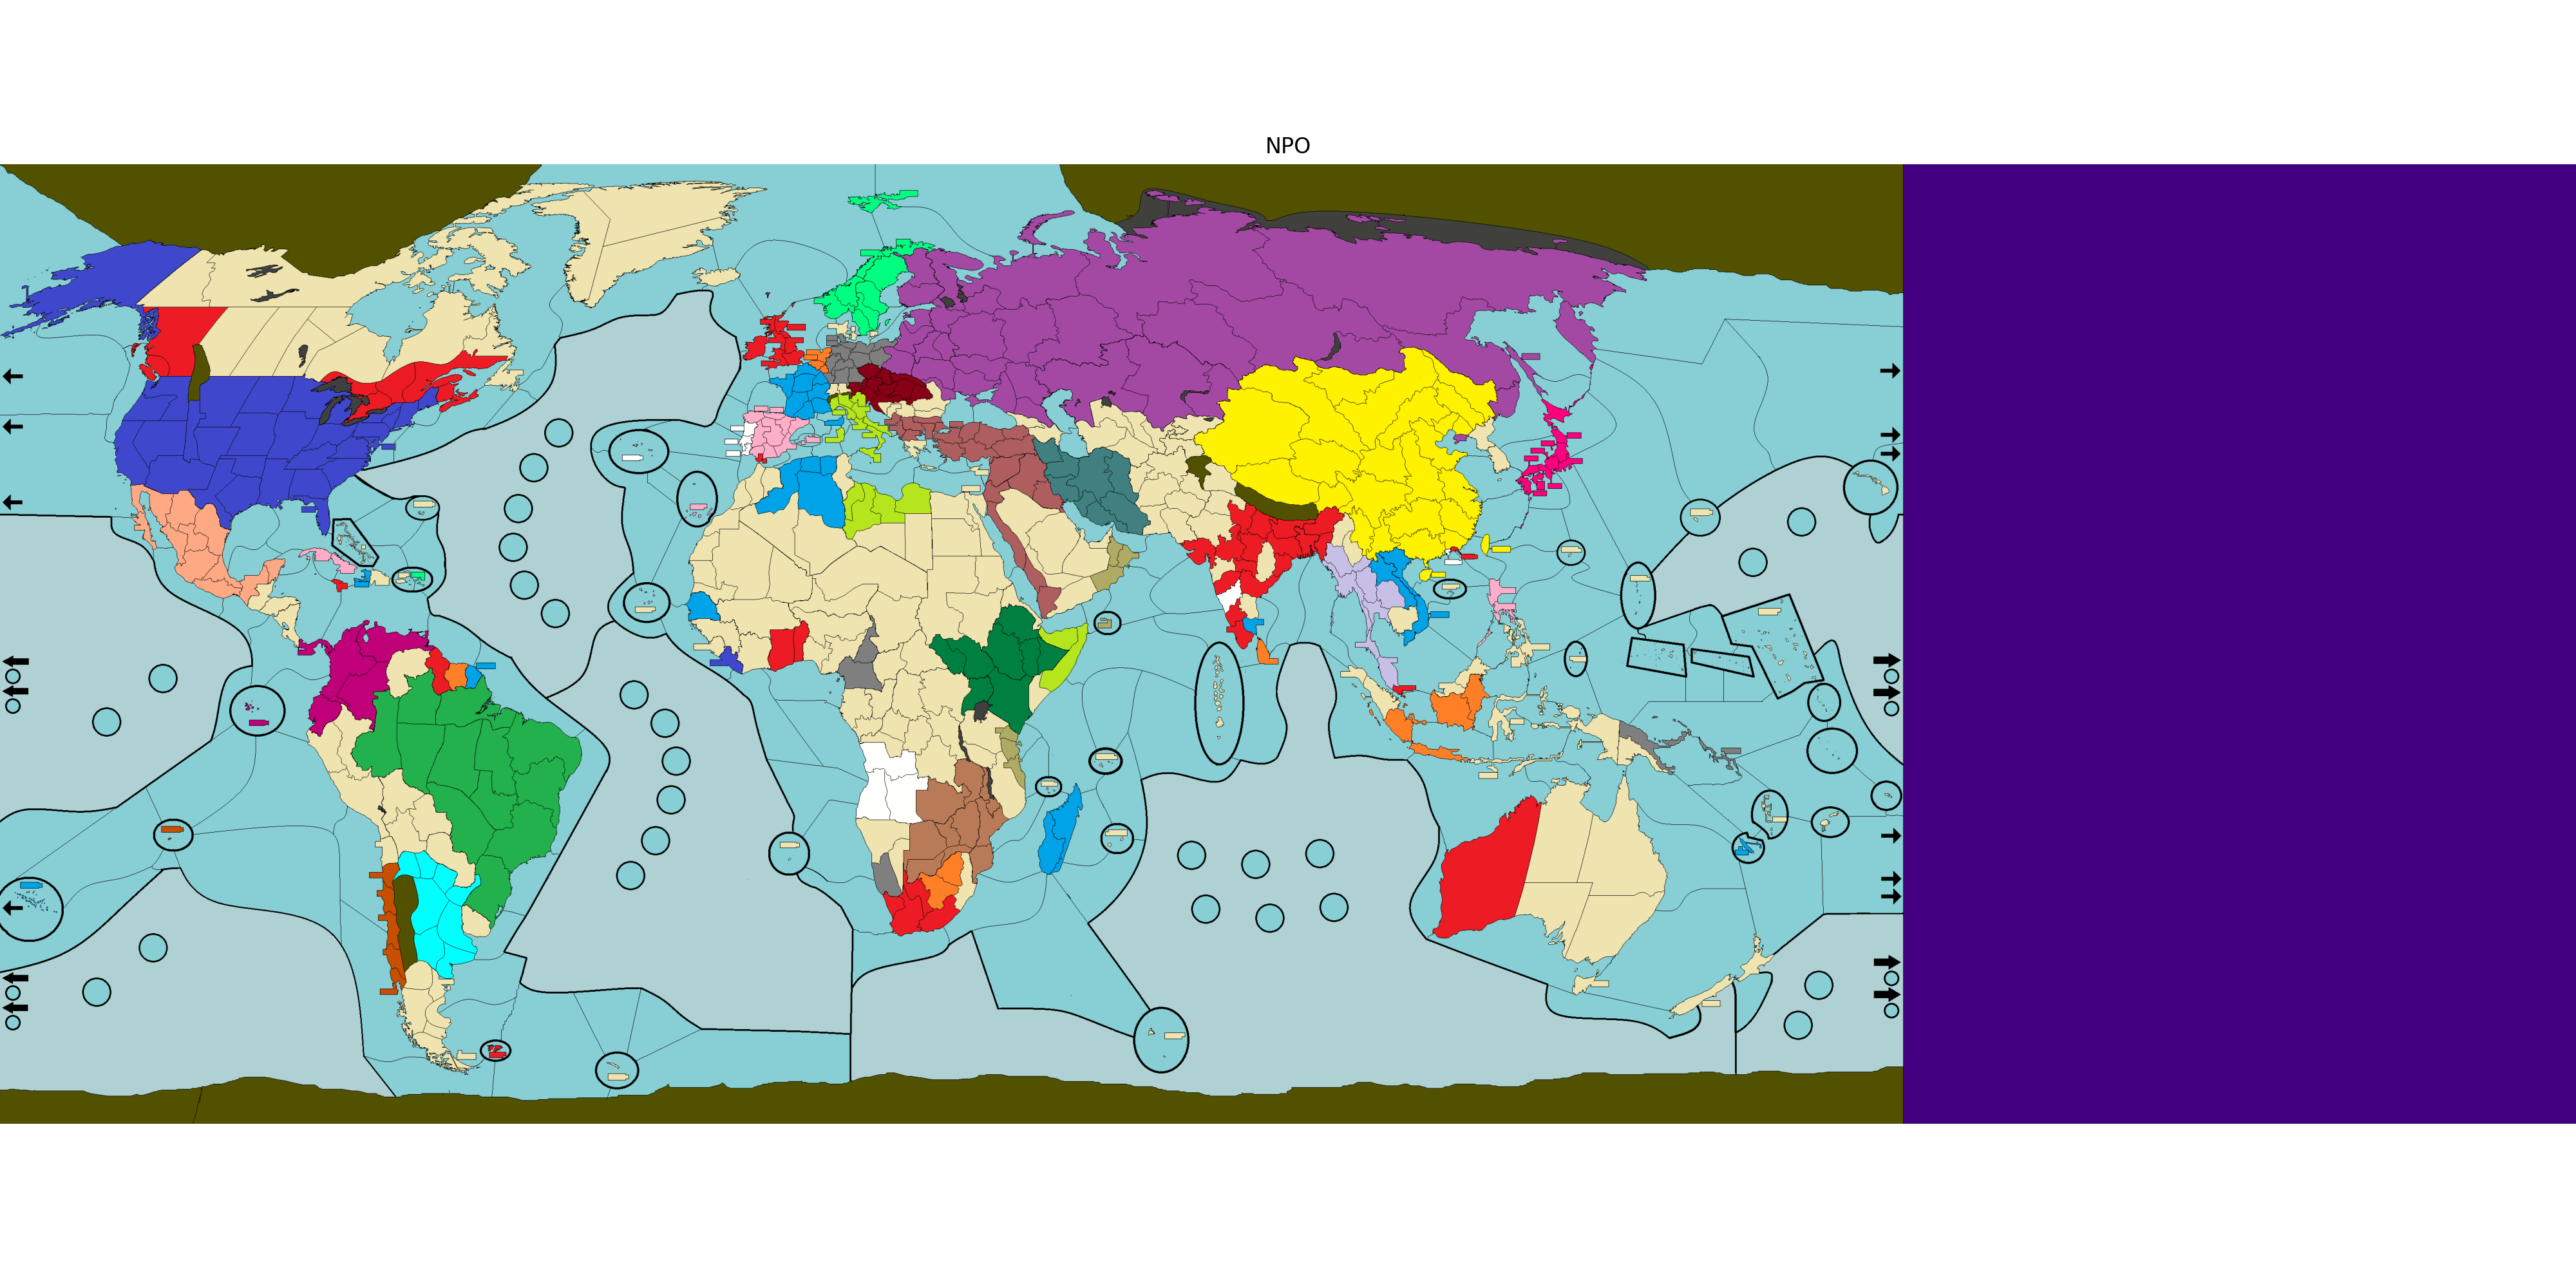

  0%|          | 0/32 [00:00<?, ?it/s]

In [55]:
fg,ax = plt.subplots(figsize=(20,10))

rgbimg = rgb.copy().astype(int)

todo = iter(tqdm([w for w in work if w not in mpicked]))
dpicked = {v:k for k,v in mpicked.items()}
current = None

def _next_prompt():
    global current
    
    try:
        current = next(todo)
        plt.title(current)
    except StopIteration:
        plt.clf()
        plt.xlabel('Done!')
        

def _onkey(event=None):
    key = None if event is None else event.key
    if key == 'a':
        _next_prompt()
        
def _onclick(event):
    global current

    btn = event.button  # 1 is left, 3 is right
    try:
        yx = [float(event.ydata), float(event.xdata)]
    except:
        return

    if btn == 3:

        yx = tuple(map(int, yx))
        val = slbls[yx]
        
        if val in picked or val in dpicked:
            plt.xlabel(f'ERROR: {val} already linked with {picked.get(val,dpicked.get(val,None))}')
            return
            
        else:
        
            rgbimg[slbls==val] = [0,0,0]
            plt.cla()
            plt.title(current)
            plt.imshow(rgbimg)

            if current not in mpicked:
                mpicked[current] = []
            mpicked[current].append(val)
            dpicked[val] = current

            plt.xlabel(f'{val} is now linked to {current} ({mpicked[current]})')
            
            if not multi_index:
                _next_prompt()
            

    else:  # invalid button
        plt.xlabel(f'unknown button: {btn}')
        return
fg.canvas.mpl_connect('button_press_event', _onclick)
fg.canvas.mpl_connect('key_press_event', _onkey)
for val in mpicked.values():
    rgbimg[slbls==val] = [0,0,0]
plt.imshow(rgbimg)
plt.axis('off')
plt.subplots_adjust(0,0,1,1);
_next_prompt()

In [56]:
# del mpicked['NPOE']
# plt.clf()

In [57]:
# print(mpicked)
mpicked1 = {'NPO': [913, 769], 'SPO': [1614, 1681], 'NAO': [213], 'SAO': [1154], 'INO': [1235], 'NAO1': [627], 'NAO2': [752], 'NAO3': [851], 'NPO1': [1300, 895], 'NAO4': [955], 'NPO2': [987, 1358], 'NAO5': [1040], 'NAO6': [1102], 'NPO4': [1367, 1284], 'SAO1': [1327], 'NPO3': [1301, 1393], 'SAO2': [1398], 'SAO3': [1478], 'SAO4': [1522], 'SAO5': [1574], 'INO3': [1589], 'INO1': [1591], 'INO2': [1600], 'SAO6': [1609], 'INO6': [1638], 'INO4': [1641], 'INO5': [1666], 'SPO4': [1734, 1688], 'SPO1': [1728, 1707], 'SPO3': [1708, 1722], 'SPO2': [1739, 1740]}
mpicked2 = {'BERI': [6, 165]}
mpicked = {**mpicked1, **mpicked2}

In [58]:
# highlight(rgb, expand_labels(slbls==750, 20))

In [59]:
for n,ii in mpicked.items():
    for i in ii:
        linked[i] = n
len(linked)

759

In [60]:
# remaining = rgb.copy()
# for val in tqdm(list(linked.keys())):
#     remaining[slbls==val] = [0,0,0]
# showx(remaining)
# showx(rgb)

# Identify Islands

Islands are tiles which surround all other tiles that need to be connected into a region (thereby making merging relatively simple).

In [61]:
islands = []

<IPython.core.display.Javascript object>


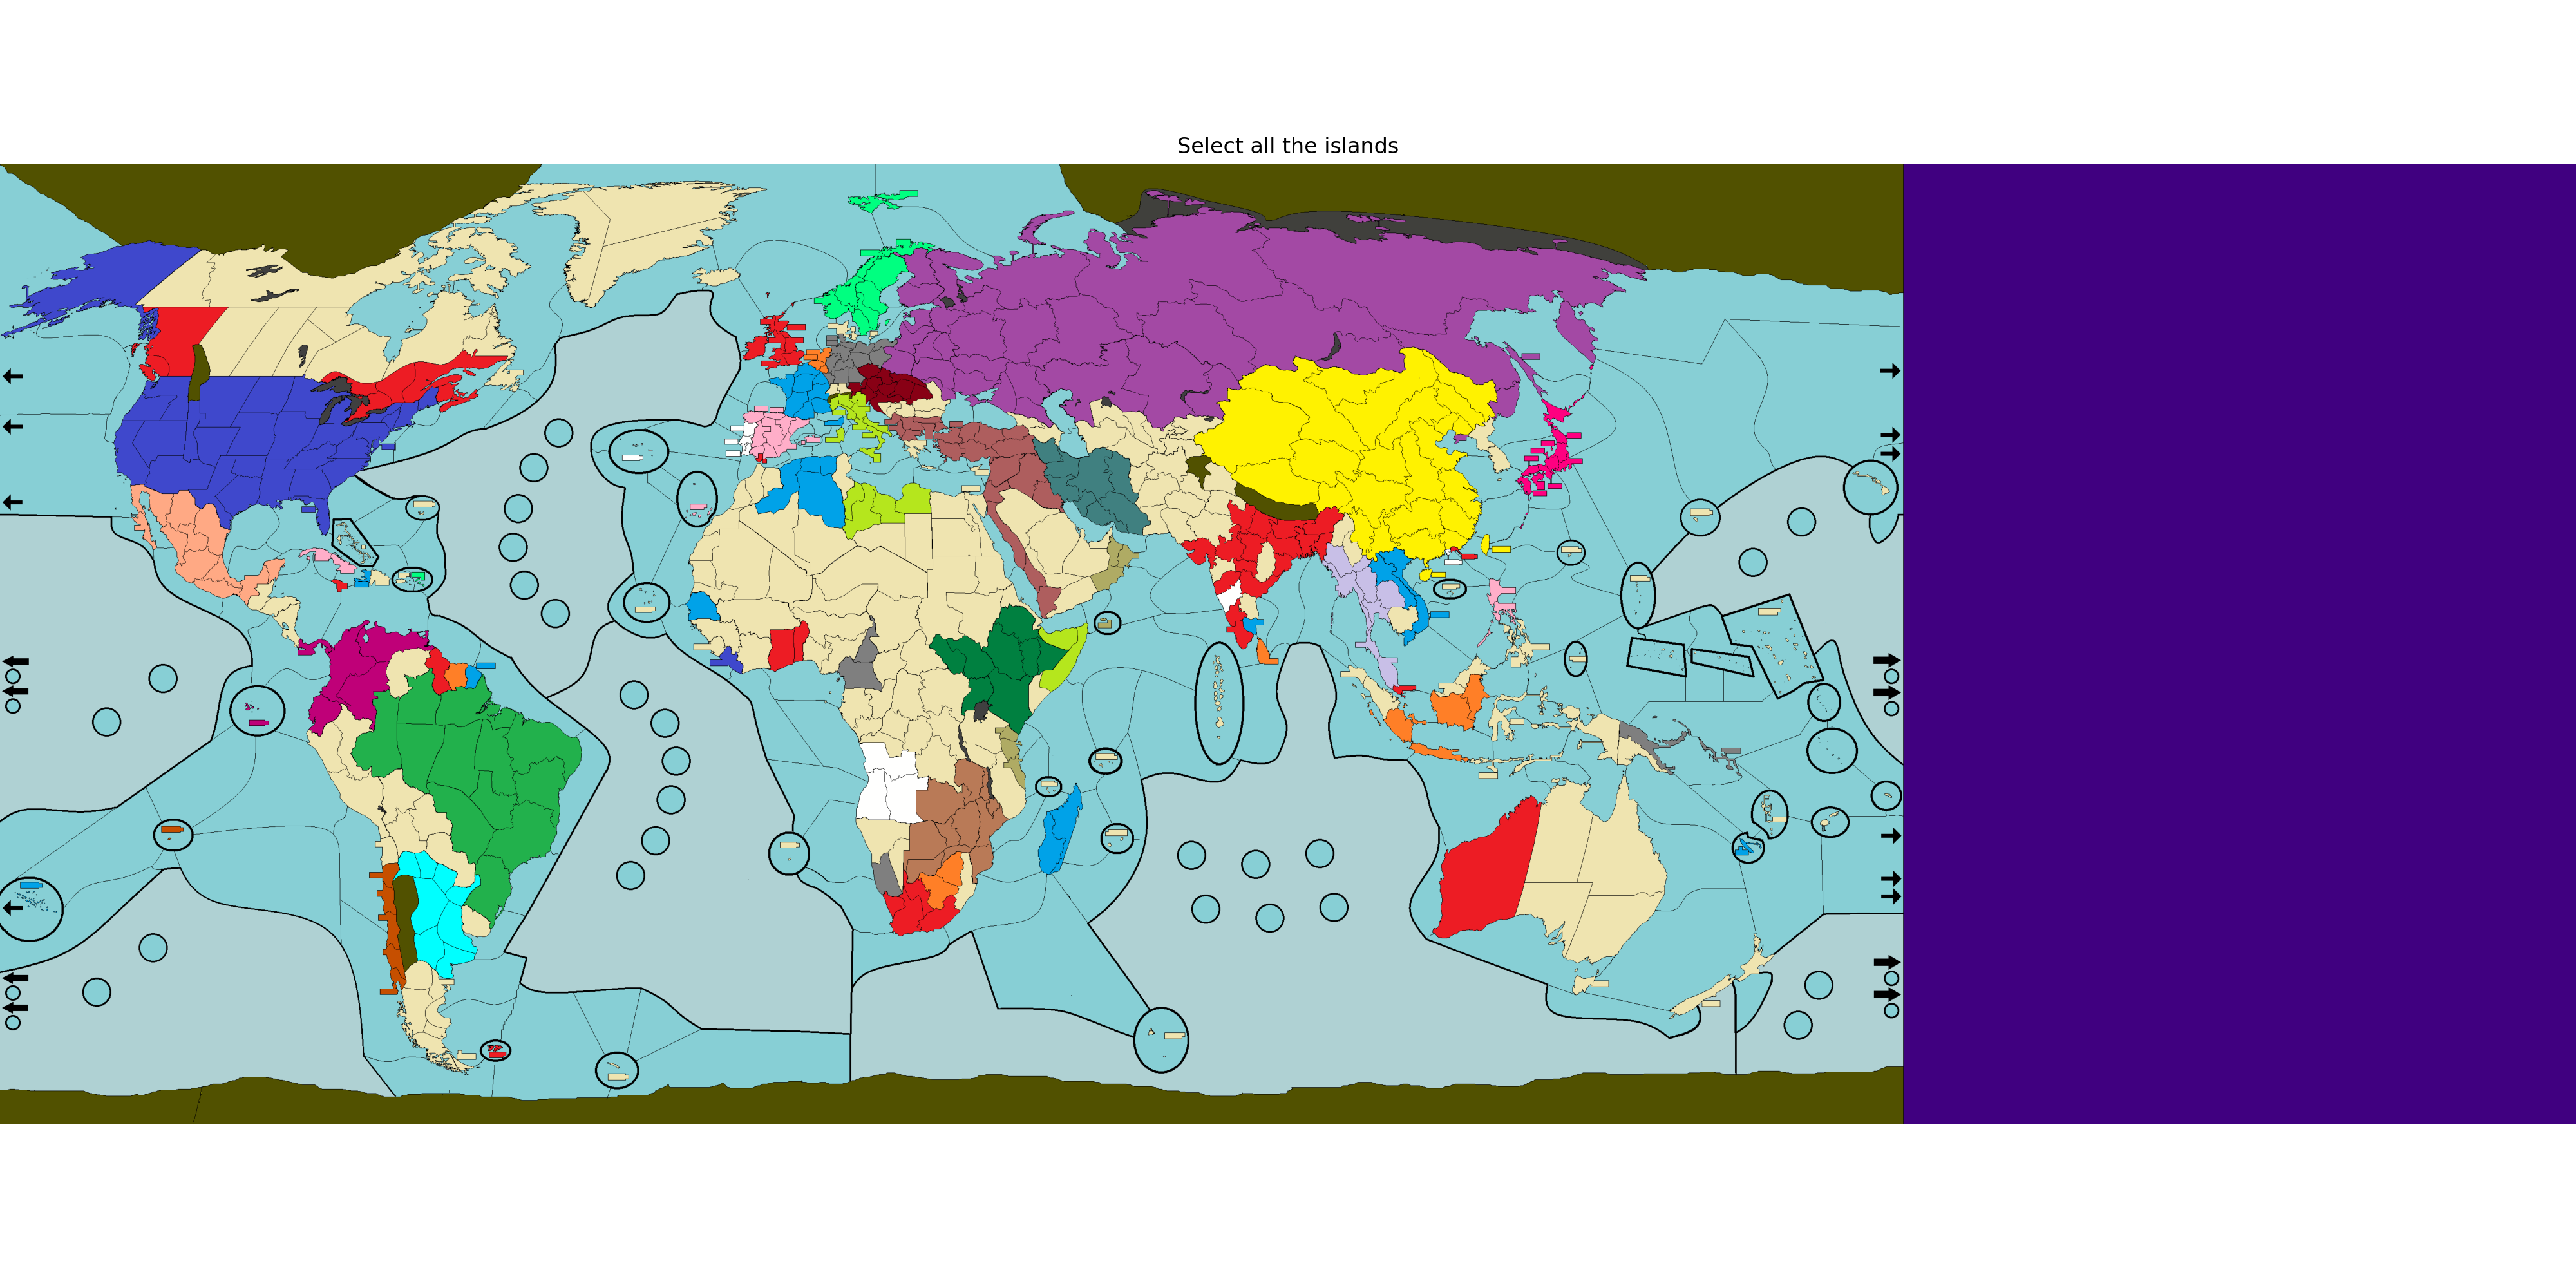

In [62]:
fg,ax = plt.subplots(figsize=(20,10))

rgbimg = rgb.copy()

def _onclick(event):
    btn = event.button  # 1 is left, 3 is right
    try:
        yx = [float(event.ydata), float(event.xdata)]
    except:
        return
    if btn == 3:
        yx = tuple(map(int, yx))
        val = slbls[yx]
        msg = []
        if val in islands:
            msg.append(f'removed {val}')
            islands.remove(val)
            rgbimg[slbls==val] = rgb[slbls==val]
        else:
            rgbimg[slbls==val] = [0,0,0]
            islands.append(val)
        msg.append(str(islands))
        
        plt.cla()
        plt.imshow(rgbimg)
        plt.title('Select all the islands')
        plt.xlabel('\n'.join(msg))
    else:  # invalid button
        plt.xlabel(f'unknown button: {btn}')
        return
fg.canvas.mpl_connect('button_press_event', _onclick)
# for val in islands:
#     rgbimg[slbls==val] = [0,0,0]
plt.imshow(rgbimg)
plt.title('Select all the islands')
plt.axis('off')
plt.subplots_adjust(0,0,1,1);

In [63]:
islands = [1031, 778, 1036, 1550, 923, 1569, 673, 1570, 804, 1057, 1066, 1580, 1452, 1581, 1331, 1334, 1093, 1479, 968, 1223, 1738, 1231, 1234, 853, 1622, 1758, 867, 1125, 1256, 1516, 1773, 1520, 1529, 1022, 677]
print(islands)

[1031, 778, 1036, 1550, 923, 1569, 673, 1570, 804, 1057, 1066, 1580, 1452, 1581, 1331, 1334, 1093, 1479, 968, 1223, 1738, 1231, 1234, 853, 1622, 1758, 867, 1125, 1256, 1516, 1773, 1520, 1529, 1022, 677]


In [64]:
# showx(blbls - mask.astype(int)*100)

In [65]:
# tile = tiles[1024]
# bim = tile.image
# cbim = tile.convex_image
# bim.shape, cbim.shape

In [66]:
# tile.coords

In [67]:
def invert_importances(imps):
    inv = {}
#     mx = None
#     mxvs = []
    for u, vs in imps.items():
        for v,w in vs.items():
            if v not in inv:
                inv[v] = Counter()
            assert u not in inv[v]
            inv[v][u] = w
    return inv

def best_matching(imps, strict=True, exclusive=False):
    inv = invert_importances(imps)
    errors, undecided = [], []
    
    def _find_min():
        while len(inv):
            best = None
            least = []
            for v, us in inv.items():
                if best is None or len(us) <= best:
                    if best is None or len(us) < best:
                        best = len(us)
                        least.clear()
                    least.append(v)
            best = None
            
            wts = Counter()
            for v in least:
                fine = True
                us = inv[v]
                if len(us):
                    
                    if len(us) > 1 and strict:
                        (u,w), (u2,w2) = us.most_common(2)
                        if w > w2:
                            wts[v] = (w, u)
                    else:
                        u, w = us.most_common(1)[0]
                        wts[v] = (w, u)
            
            if not len(wts):
                undecided.extend(inv.keys())
                break
            else:
                v, (w,u) = wts.most_common(1)[0]
                yield v, inv[v]
                del inv[v]
    
    picks = {}
    for i, (v, us) in enumerate(_find_min()):
        us = us.most_common()
        if len(us):
            mx = us[0][1]
            us = [u for u,w in us if w == mx]
            if len(us) > 1:
                picks[v] = us
                
            else:
                u = us[0]
                picks[v] = u
            if exclusive:
                for u in us:
                    for v2 in imps[u]:
                        if v2 != v and v2 in inv:
                            del inv[v2][u]
                            if len(inv[v2]) == 0:
                                errors.append(v2)
                                del inv[v2]

    return picks, undecided, errors
    
    
def convex_mask(tile):
    mask = np.zeros_like(slbls)
    rmn, cmn, rmx, cmx = tile.bbox
    mask[rmn:rmx,cmn:cmx] = tile.convex_image
    mask = mask.astype(bool)
    return mask

In [68]:
idx = 1031

In [69]:
lisles = {}
bisles = {}
for i in tqdm(islands):
    mask = convex_mask(tiles[i])
    cnt = Counter(slbls[mask].tolist())
    bnt = Counter(blbls[mask].tolist())
    if 0 in cnt:
        del cnt[0]
    if 0 in bnt:
        del bnt[0]
    lisles[i] = cnt
    bisles[i] = bnt
len(lisles)

  0%|          | 0/35 [00:00<?, ?it/s]

35

In [70]:
inv = invert_importances(bisles)
len(bisles), len(inv)

(35, 38)

In [71]:
bnns, loop, errors = best_matching(bisles,exclusive=True)
len(bnns), len(loop), len(errors)

(35, 0, 3)

In [72]:
{k:lbltiles[k].area for k in errors}

{383: 1, 385: 4, 438: 1}

In [73]:
idents = {t:fixed[l-1] for l, t in bnns.items()}
print(idents)

{1093: 'AOLE', 867: 'WAKE', 1773: 'SNDW', 1570: 'MAUR', 1569: 'RAPA', 1452: 'TUVA', 1256: 'NAUR', 1234: 'MALD', 778: 'HAWA', 1622: 'TUAM', 1479: 'MAHE', 1223: 'CARO', 853: 'BERM', 1738: 'MCD', 673: 'AZOR', 1520: 'TONG', 968: 'GUAM', 1550: 'FIJI', 1331: 'KIRI', 1066: 'VERD', 1022: 'RULL', 1580: 'STHE', 1334: 'GALA', 1758: 'FALK', 804: 'CANA', 1231: 'PALU', 1057: 'XISH', 1529: 'VANU', 677: 'BALE', 1581: 'CALE', 1516: 'COMO', 1125: 'SOCO', 1031: 'STBE', 1036: 'PR', 923: 'BAHA'}


In [74]:
# highlight(rgb, expand_labels(blbls==383, 50))

In [75]:
cnns, undecided, errors = best_matching(lisles,strict=True,exclusive=False)
len(cnns), len(undecided), len(errors)

(240, 1, 0)

In [76]:
print(undecided)

[1055]


In [77]:
island_tiles = {v:idents[u] for v, u in cnns.items() if v not in linked}


In [78]:
for il in tqdm(islands):
    name = idents[il]
    watername = f'{name}-water'
    color = Counter(map(tuple,rgb[slbls==il])).most_common(1)[0][0]
    island_tiles[il] = watername
    for v,n in island_tiles.items():
        if n == name:
            c = Counter(map(tuple,rgb[slbls==v])).most_common(1)[0][0]
            if c == color:
                island_tiles[v] = watername

  0%|          | 0/35 [00:00<?, ?it/s]

In [79]:
linked2 = {**linked, **island_tiles}
len(linked2)

958

In [80]:
new = {}
for v,n in linked2.items():
    if n not in new:
        new[n] = []
    new[n].append(v)
len(new)
# print(new.keys())

781

In [75]:
# highlight(rgb, sum(slbls==x for x in lisles[idx]))
# highlight(rgb, sum(slbls==x for x in new['OUES']), 0.1)

In [457]:
# showx(slbls%1000)

In [445]:
# highlight(rgb, convex_mask(tiles[1105]))

In [496]:
# showx(rgb * np.expand_dims(1-sum(v==slbls for v in tqdm(linked2)).astype(bool),-1))

In [382]:
# highlight(rgb, expand_labels(blbls==fixed.index('ORAB')+1, 50))

In [126]:
# highlight(rgb, convex_mask(tiles[1031]))

# Colors

In [81]:
# by color

colortypes = {
    'bg': [(64, 0, 128)],
    'mountain': [(81, 81, 0)],
    'lake': [(64, 64, 64)],
#     'ocean': [(175, 209, 211)],
    'arctic': [(64, 64, 60)],
}
sea = (135, 207, 213)

In [82]:
def color_mask(rgb, colors, ):
    mask = None
    for c in colors:
        c = np.array(c).astype(int).reshape(1,1,-1)
        new = np.abs(rgb-c).sum(-1) == 0
        if mask is None:
            mask = new
        else:
            mask += new
    return mask

In [83]:
typ = 'lake'
cs = colortypes[typ]

In [84]:
mask = color_mask(rgb, cs)

In [85]:
cts = Counter(slbls[mask])
if 0 in cts:
    del cts[0]
print(cts)

Counter({475: 1629, 1360: 1120, 534: 1082, 544: 985, 149: 721, 349: 693, 210: 612, 1448: 501, 1506: 441, 387: 437, 616: 437, 218: 434, 547: 364, 589: 336, 519: 329, 201: 321, 621: 120, 434: 81, 1544: 58, 542: 38, 1547: 27, 529: 24, 207: 23, 559: 23, 166: 13, 578: 11, 528: 9, 539: 8, 180: 7, 183: 3, 586: 3, 1551: 3, 184: 2, 424: 2, 208: 1, 440: 1, 1552: 1, 1553: 1, 1554: 1, 1557: 1, 1558: 1, 1560: 1})


In [86]:
bgs = {}
for typ, cs in tqdm(colortypes.items()):
    mask = color_mask(rgb, cs)
    cts = Counter(slbls[mask])
    if 0 in cts:
        del cts[0]
    for i, (l, _) in enumerate(cts.most_common()):
        bgs[l] = typ #f'{typ}{i}'
len(bgs)

  0%|          | 0/4 [00:00<?, ?it/s]

59

In [87]:
# highlight(rgb, expand_labels(sum(slbls==x for x in cts), 5))

<IPython.core.display.Javascript object>


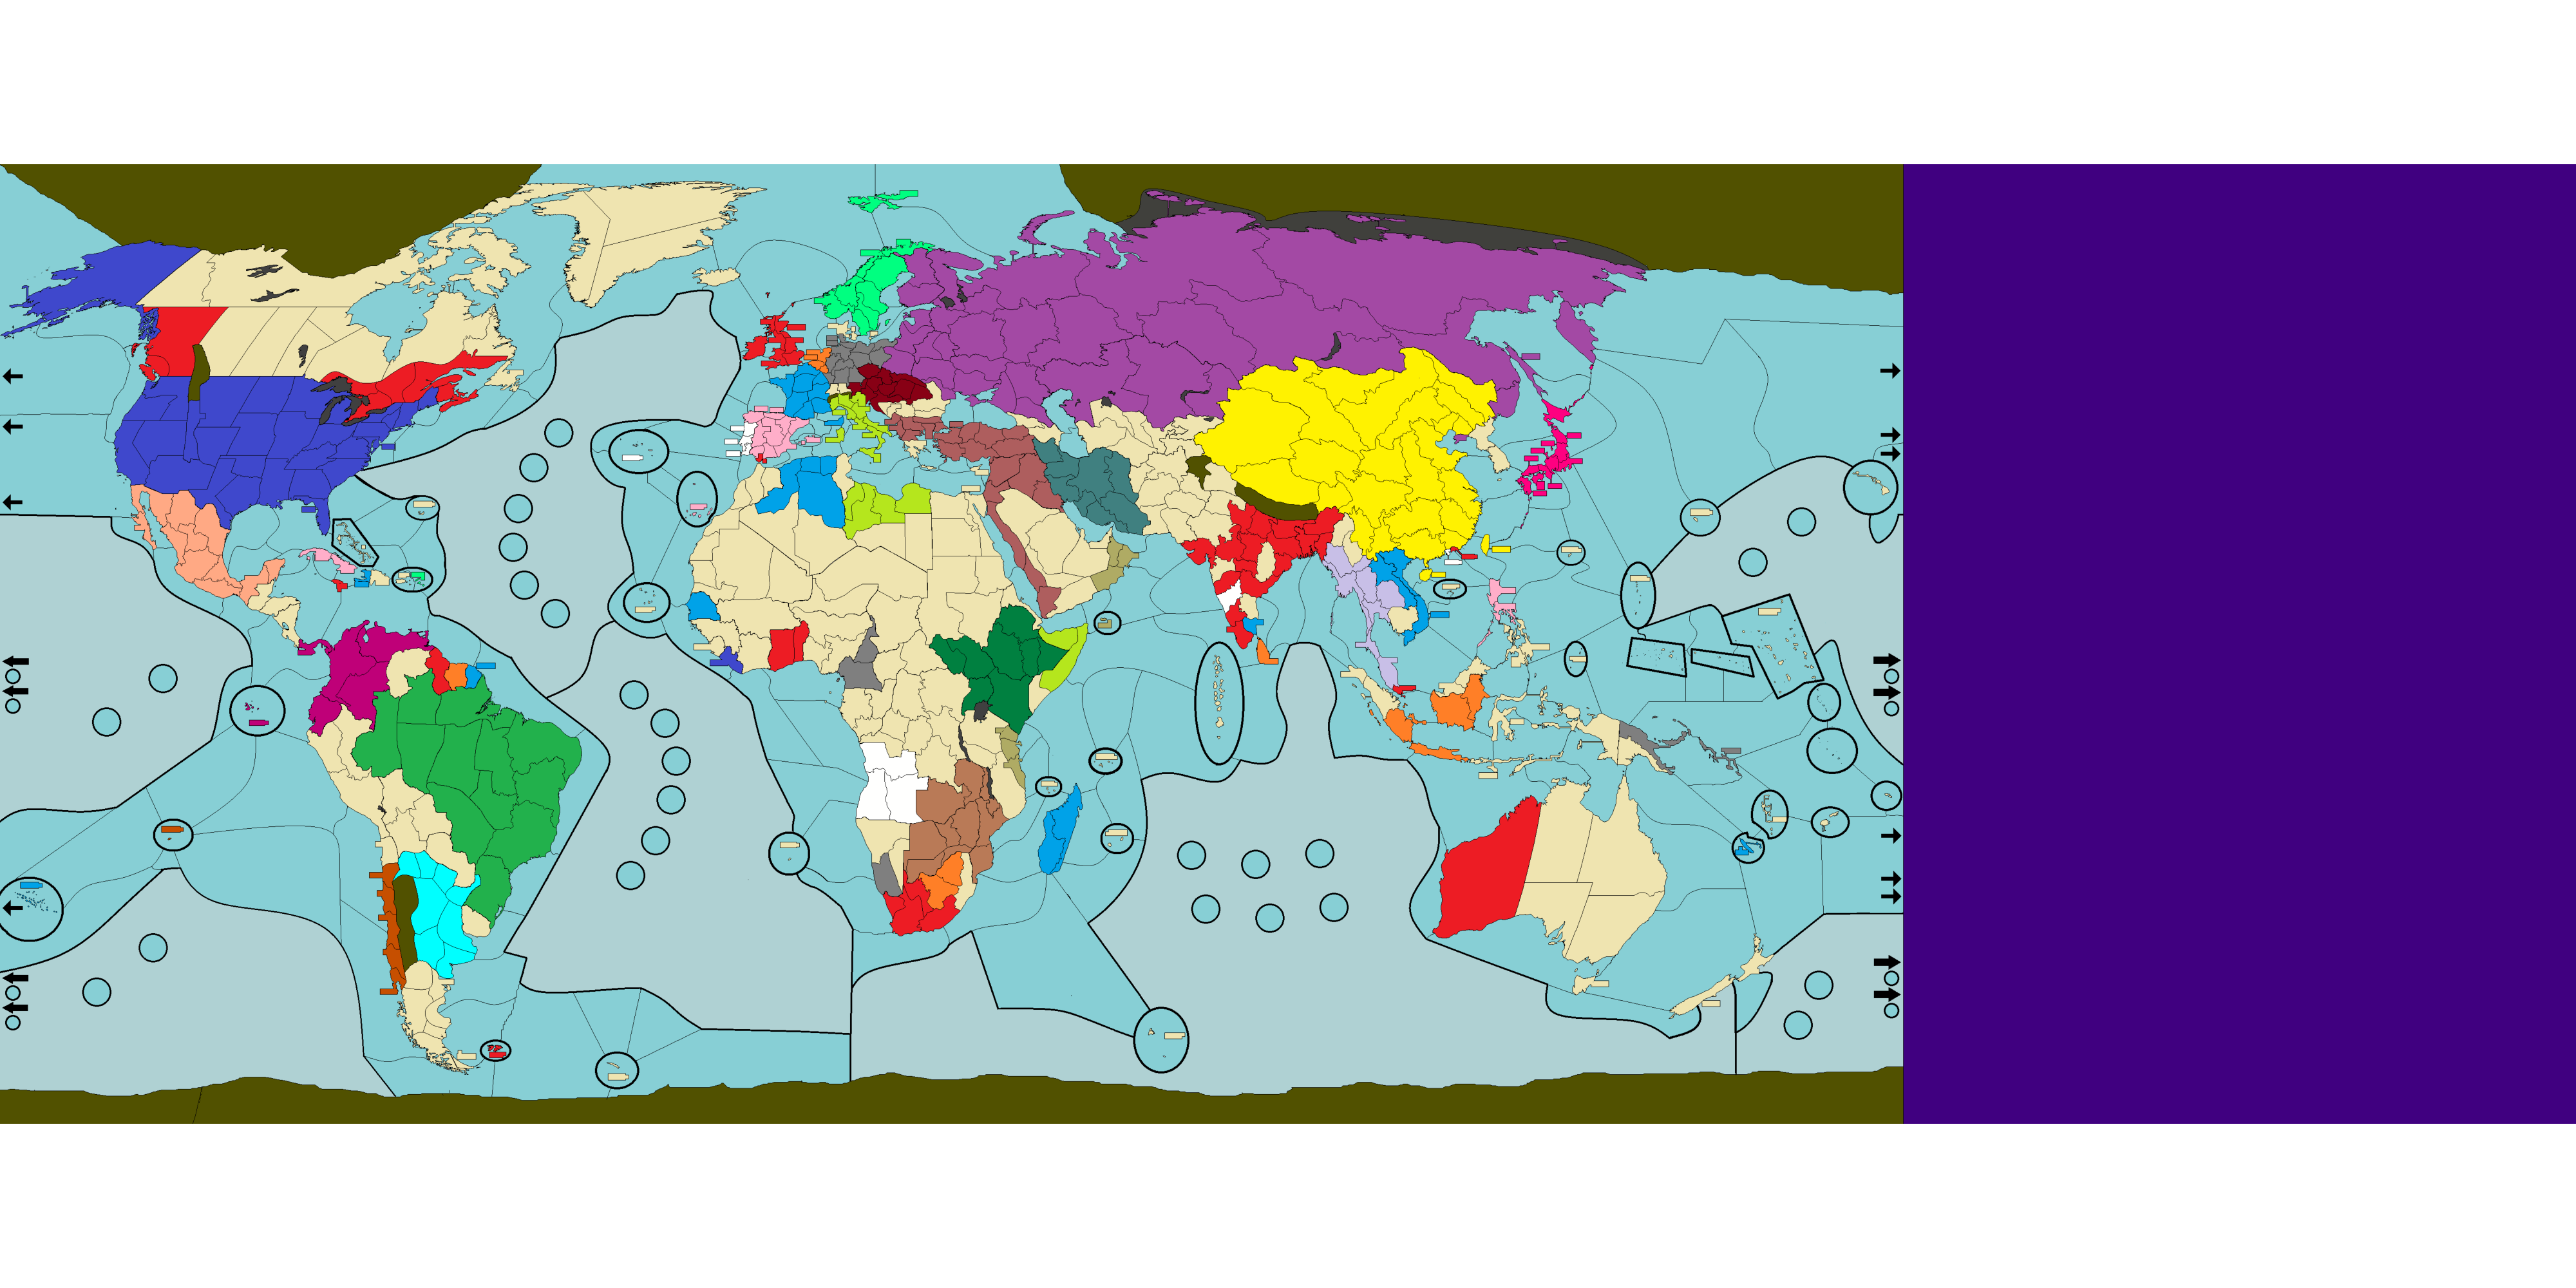

In [88]:
showx(rgb)

## What's missing?

In [89]:
assigned = sum(v==slbls for v in tqdm({**linked2, **bgs})).astype(bool)

  0%|          | 0/1017 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
manual = {637:636, 79:111, 1397:1420, 425:221, 674:536, 384:314}
assigned += sum(v==slbls for v in manual).astype(bool)

In [ ]:
# showx(rgb * np.expand_dims(1-remaining).astype(bool),-1)
# highlight(rgb, expand_labels(1-(assigned+(slbls==0).astype(int)), 3))

In [ ]:
sizes = Counter({i:tiles[i].area for i in range(1,slbls.max()+1) if i not in linked2 and i not in bgs and i not in manual})
len(sizes)

In [ ]:
print(sizes.most_common(5))

In [ ]:
remaining = sum(v==slbls for v in tqdm(sizes)).astype(bool)

In [ ]:
# highlight(rgb, expand_labels(remaining, 3), cover=slbls)

In [ ]:
H,W = slbls.shape
grid = np.mgrid[0:H, 0:W].transpose(1,2,0)
grid.shape

In [ ]:
owners = {}
unique = Counter()

In [ ]:
for idx, area in tqdm(sizes.most_common()):
    if idx not in owners:
        color = Counter(map(tuple, rgb[slbls==idx])).most_common(1)[0][0]

        available = np.abs(rgb-np.array(color).astype(int).reshape(1,1,-1)).sum(-1) == 0
        available = available.astype(int) - (slbls == idx)
        available = available.astype(bool) * assigned

        if available.sum() == 0:
            unique[idx] = area
        else:
        
            ct = grid[slbls==idx].mean(0,keepdims=True)
            coords = grid[available]
            dists = np.sqrt(((coords-ct)**2).sum(-1))
            owner = slbls[tuple(coords[dists.argmin()])]
            owners[idx] = owner
len(owners)

In [ ]:
unique

In [ ]:
# highlight(rgb, expand_labels(sum(slbls==i for i in unique), 10))

In [121]:
owners = {63: 65, 1175: 1104, 1202: 1049, 70: 30, 60: 30, 382: 249, 1671: 1676, 1158: 1128, 787: 697, 150: 111, 1782: 1778, 798: 792, 46: 3, 1725: 1704, 708: 649, 991: 990, 1691: 1625, 298: 215, 1396: 1392, 1451: 1431, 1715: 1699, 1357: 1307, 172: 111, 291: 227, 373: 314, 1247: 1128, 224: 227, 254: 227, 1511: 1463, 263: 65, 449: 561, 1433: 1431, 1737: 1652, 364: 238, 371: 219, 570: 561, 217: 100, 289: 100, 1775: 1778, 1007: 984, 380: 393, 284: 227, 388: 30, 1724: 1699, 120: 111, 538: 561, 925: 876, 1317: 1266, 701: 636, 775: 698, 814: 720, 326: 227, 1415: 1431, 1700: 1680, 1136: 1016, 214: 282, 359: 332, 715: 698, 1133: 1119, 348: 345, 365: 238, 500: 435, 237: 280, 288: 6, 659: 527, 1493: 1440, 1706: 1713, 75: 2, 863: 859, 1208: 1119, 1213: 1049, 1228: 1129, 1424: 1431, 1705: 1713, 460: 30, 724: 664, 109: 52, 159: 6, 799: 792, 840: 791, 930: 865, 1774: 1733, 81: 3, 88: 3, 663: 525, 1123: 1016, 1329: 1286, 1742: 1652, 1762: 1751, 267: 227, 328: 227, 717: 698, 954: 876, 36: 30, 97: 8, 265: 280, 937: 810, 1373: 1392, 1406: 1229, 1770: 1652, 1771: 1733, 37: 2, 384: 332, 562: 561, 565: 558, 580: 561, 905: 810, 1157: 1016, 1347: 1330, 1362: 1335, 76: 30, 103: 3, 147: 52, 315: 227, 603: 486, 1127: 1104, 1152: 1104, 1382: 1392, 1467: 1431, 158: 3, 369: 332, 390: 337, 692: 664, 1026: 1014, 1118: 1019, 1210: 1119, 1350: 1349, 1438: 1392, 1487: 1463, 186: 165, 573: 468, 1185: 1186, 1219: 1227, 1453: 1332, 1582: 1578, 1787: 1778, 49: 30, 55: 2, 80: 30, 139: 3, 148: 6, 177: 6, 350: 282, 881: 876, 886: 859, 1209: 1129, 1447: 1420, 43: 2, 143: 3, 211: 100, 229: 6, 304: 227, 381: 219, 394: 227, 396: 314, 501: 498, 524: 527, 809: 746, 862: 810, 1086: 1090, 1095: 1062, 1342: 1335, 1369: 1229, 1381: 1392, 1388: 1374, 1418: 1392, 1425: 1229, 1709: 1713, 18: 2, 22: 2, 25: 2, 136: 3, 144: 3, 171: 99, 189: 30, 290: 282, 338: 227, 353: 227, 505: 498, 537: 510, 596: 486, 658: 664, 671: 664, 687: 525, 699: 649, 734: 697, 735: 607, 933: 859, 942: 810, 1117: 1119, 1370: 1229, 1428: 1392, 1457: 1420, 1465: 1431, 1526: 1450, 1689: 1680, 1801: 1778, 11: 2, 14: 2, 34: 2, 41: 2, 58: 30, 94: 30, 161: 6, 187: 30, 253: 221, 276: 227, 320: 188, 322: 227, 331: 247, 339: 282, 448: 561, 530: 489, 739: 698, 848: 834, 855: 810, 914: 876, 1025: 986, 1038: 1004, 1254: 1186, 1333: 1286, 1346: 1330, 1364: 1229, 1378: 1229, 1606: 1598, 1761: 1652, 1783: 1778, 1799: 1778, 15: 2, 16: 2, 23: 2, 27: 2, 35: 2, 53: 2, 54: 2, 73: 30, 82: 30, 84: 30, 86: 30, 102: 30, 116: 52, 117: 99, 118: 52, 126: 52, 128: 52, 133: 2, 198: 111, 199: 2, 230: 227, 260: 212, 270: 30, 283: 238, 286: 227, 301: 227, 313: 227, 325: 227, 343: 345, 392: 212, 461: 383, 466: 561, 495: 498, 511: 435, 540: 510, 690: 676, 695: 664, 703: 664, 721: 664, 767: 698, 777: 760, 795: 720, 822: 760, 878: 834, 922: 876, 935: 864, 936: 834, 963: 915, 1101: 992, 1201: 1119, 1204: 1119, 1353: 1339, 1365: 1392, 1371: 1229, 1408: 1229, 1410: 1229, 1436: 1443, 1441: 1420, 1466: 1392, 1750: 1652, 1752: 1652, 1780: 1652, 1781: 1778, 1785: 1778, 1794: 1778, 1798: 1778, 9: 2, 12: 2, 13: 2, 32: 2, 59: 30, 62: 30, 69: 30, 74: 30, 85: 30, 89: 65, 92: 30, 105: 3, 113: 52, 125: 111, 127: 111, 137: 111, 151: 30, 152: 165, 153: 3, 155: 3, 163: 99, 170: 99, 175: 165, 176: 99, 196: 111, 204: 100, 225: 99, 226: 99, 228: 6, 241: 6, 243: 221, 248: 238, 271: 221, 275: 6, 277: 30, 279: 6, 292: 255, 293: 227, 295: 227, 306: 227, 310: 227, 311: 227, 318: 227, 319: 227, 329: 30, 488: 383, 494: 435, 533: 383, 581: 558, 595: 486, 600: 604, 602: 486, 623: 428, 688: 661, 691: 676, 741: 697, 755: 670, 776: 697, 782: 725, 794: 760, 847: 789, 887: 828, 907: 876, 927: 864, 940: 865, 952: 876, 958: 864, 1008: 859, 1009: 1004, 1013: 969, 1030: 989, 1141: 1069, 1196: 1104, 1272: 1129, 1306: 1274, 1313: 1259, 1354: 1392, 1356: 1229, 1361: 1229, 1376: 1392, 1414: 1397, 1437: 1440, 1477: 1449, 1498: 1463, 1541: 1528, 1545: 1528, 1562: 1525, 1605: 1598, 1682: 1676, 1683: 1676, 1696: 1565, 1711: 1712, 1727: 1680, 1736: 1652, 1755: 1652, 1757: 1652, 1760: 1652, 1764: 1652, 1769: 1652, 1786: 1778, 1790: 1778, 1792: 1778, 1793: 1778, 1800: 1778, 10: 2, 17: 2, 19: 2, 20: 2, 21: 2, 33: 2, 38: 30, 39: 30, 45: 3, 47: 2, 48: 2, 50: 3, 51: 2, 56: 2, 61: 30, 64: 3, 67: 2, 68: 30, 71: 2, 72: 2, 77: 79, 78: 30, 83: 3, 87: 30, 90: 30, 91: 30, 93: 30, 96: 30, 98: 30, 104: 30, 106: 3, 107: 30, 108: 52, 110: 111, 112: 30, 114: 99, 115: 99, 119: 52, 121: 30, 130: 30, 132: 2, 135: 111, 138: 2, 140: 99, 141: 30, 142: 2, 145: 2, 146: 6, 154: 6, 156: 6, 157: 3, 162: 6, 164: 99, 167: 99, 168: 6, 169: 99, 173: 111, 178: 2, 179: 2, 182: 30, 185: 52, 190: 30, 191: 30, 192: 30, 193: 99, 202: 100, 203: 100, 209: 100, 232: 6, 233: 227, 234: 99, 235: 280, 236: 280, 239: 227, 240: 221, 244: 221, 245: 6, 246: 6, 256: 30, 258: 227, 261: 280, 264: 227, 266: 227, 268: 6, 269: 227, 272: 6, 273: 6, 274: 6, 278: 238, 281: 238, 285: 238, 287: 227, 296: 227, 300: 227, 302: 221, 307: 227, 309: 227, 312: 227, 321: 227, 323: 30, 324: 227, 327: 227, 333: 227, 336: 227, 340: 282, 341: 282, 342: 282, 344: 345, 347: 282, 351: 282, 354: 303, 355: 317, 356: 317, 357: 368, 358: 227, 360: 317, 361: 317, 362: 257, 363: 257, 366: 368, 370: 308, 374: 30, 376: 238, 386: 30, 391: 30, 395: 30, 397: 383, 398: 30, 403: 30, 405: 383, 407: 212, 408: 212, 411: 212, 412: 212, 413: 212, 418: 383, 420: 383, 423: 383, 429: 383, 430: 247, 433: 414, 436: 437, 438: 480, 439: 383, 447: 383, 456: 30, 457: 30, 458: 30, 459: 30, 477: 111, 479: 111, 483: 435, 491: 383, 497: 435, 502: 498, 503: 383, 504: 498, 506: 498, 508: 498, 513: 435, 516: 498, 520: 498, 522: 510, 541: 468, 543: 515, 545: 468, 548: 468, 549: 558, 552: 558, 553: 551, 555: 515, 556: 551, 557: 558, 563: 551, 566: 468, 571: 468, 576: 558, 582: 558, 587: 649, 588: 558, 591: 558, 594: 471, 633: 515, 644: 515, 645: 515, 646: 561, 647: 649, 648: 515, 651: 561, 654: 655, 656: 655, 662: 525, 668: 525, 681: 664, 684: 676, 694: 649, 702: 664, 713: 632, 726: 725, 727: 653, 729: 664, 730: 607, 732: 607, 738: 670, 740: 697, 754: 698, 761: 649, 768: 664, 779: 649, 808: 763, 811: 810, 812: 758, 813: 758, 820: 760, 823: 760, 824: 760, 829: 760, 836: 760, 839: 760, 844: 760, 846: 789, 849: 792, 850: 834, 856: 213, 860: 859, 861: 864, 870: 859, 871: 859, 872: 864, 873: 760, 879: 859, 889: 834, 917: 607, 929: 864, 938: 865, 956: 834, 961: 876, 962: 900, 965: 876, 966: 959, 971: 919, 988: 990, 1006: 1004, 1010: 1012, 1015: 1012, 1018: 990, 1020: 1012, 1021: 1012, 1055: 1059, 1085: 1088, 1116: 1119, 1120: 1019, 1130: 1119, 1137: 1104, 1138: 1104, 1139: 1145, 1143: 1145, 1144: 992, 1151: 1104, 1155: 1016, 1156: 1104, 1160: 1104, 1161: 1142, 1163: 1104, 1164: 1168, 1165: 1168, 1166: 1168, 1167: 1168, 1169: 769, 1170: 1108, 1171: 1106, 1176: 1019, 1179: 1069, 1180: 1119, 1181: 1119, 1182: 1049, 1184: 1119, 1187: 1104, 1188: 1119, 1190: 1129, 1192: 1129, 1195: 1126, 1198: 1134, 1199: 1162, 1200: 1129, 1203: 1126, 1207: 1119, 1212: 1128, 1214: 1049, 1221: 1227, 1222: 1119, 1225: 1227, 1226: 1124, 1237: 1128, 1238: 1128, 1239: 1124, 1245: 1128, 1249: 989, 1252: 1072, 1282: 1129, 1290: 1229, 1294: 1274, 1305: 1274, 1309: 1259, 1311: 1206, 1320: 1259, 1344: 1339, 1352: 1229, 1355: 1229, 1366: 1229, 1372: 1392, 1383: 1229, 1386: 1229, 1387: 1229, 1391: 1229, 1394: 1349, 1395: 1349, 1400: 1229, 1402: 1229, 1403: 1443, 1404: 1229, 1405: 1229, 1407: 1229, 1409: 1229, 1411: 1229, 1419: 1392, 1423: 1229, 1427: 1297, 1429: 1348, 1430: 1297, 1432: 1229, 1435: 1297, 1439: 1440, 1445: 1349, 1468: 1392, 1469: 1392, 1471: 1476, 1472: 1359, 1474: 1476, 1475: 1359, 1485: 1486, 1488: 1486, 1490: 1458, 1495: 1476, 1496: 1481, 1497: 1481, 1505: 1461, 1517: 1491, 1608: 1528, 1668: 1598, 1684: 1680, 1692: 1686, 1694: 1627, 1695: 1627, 1697: 1627, 1698: 1565, 1702: 1680, 1714: 1712, 1716: 1712, 1717: 1627, 1718: 1712, 1719: 1687, 1720: 1687, 1721: 1627, 1735: 1652, 1743: 1652, 1744: 1652, 1745: 1652, 1746: 1652, 1749: 1729, 1754: 1652, 1756: 1652, 1759: 1652, 1772: 1652, 1776: 1733, 1779: 1652, 1784: 1733, 1789: 1778, 1791: 1778, 1795: 1778, 1796: 1778, 1802: 1778, 1803: 1778, 1804: 1778, 1806: 1722}
# print(owners)

In [122]:
# unique = Counter({1809: 12, 1810: 4, 1807: 2, 745: 1, 885: 1})
# print(unique)

In [123]:
linked3 = linked2.copy()
bgs2 = bgs.copy()
assignments = owners.copy()

In [124]:
for me, parent in assignments.items():
    try:
        linked3[me] = linked3.get(parent,bgs.get(parent))
    except:
        print(me, parent)
        raise
for me, parent in manual.items():
    linked3[me] = linked3.get(parent,bgs.get(parent))
for i in unique:
    bgs2[i] = 'unknown'
len(linked3), len(bgs2), slbls.max()

(1746, 59, 1810)

In [125]:
missing = []
for i in range(1,slbls.max()+1):
    if i not in linked3 and i not in bgs2:
        missing.append(i)
missing

[745, 885, 1807, 1809, 1810]

In [100]:
# highlight(rgb, expand_labels(sum(slbls==i for i in missing), 10))

In [101]:
# Image.fromarray(slbls.astype(np.int16)).save(root / "tiles.png")

In [126]:
graph = {}
for ID, name in linked3.items():
    if name not in graph:
        graph[name] = {'tiles':[], 'name':name}
    graph[name]['tiles'].append(int(ID))

bgnodes = {}
for ID, name in bgs2.items():
    if name not in bgnodes:
        bgnodes[name] = {'tiles':[], 'name':name}
    bgnodes[name]['tiles'].append(int(ID))

GRAPH = list(graph.values())
BG = list(bgnodes.values())

idx = 1
for node in GRAPH:
    node['ID'] = idx
    idx += 1
for node in BG:
    node['ID'] = idx
    idx += 1

nodes = [*GRAPH, *BG]

len(GRAPH), len(BG), len(nodes)

(782, 4, 786)

In [127]:
# save_yaml(GRAPH, root/'nodes.yaml')
# save_yaml(BG, root/'bg.yaml');

In [128]:
regions = slbls.copy()*0
for node in tqdm(nodes):
    regions[sum(slbls==i for i in node['tiles']).astype(bool)] = node['ID']

  0%|          | 0/786 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


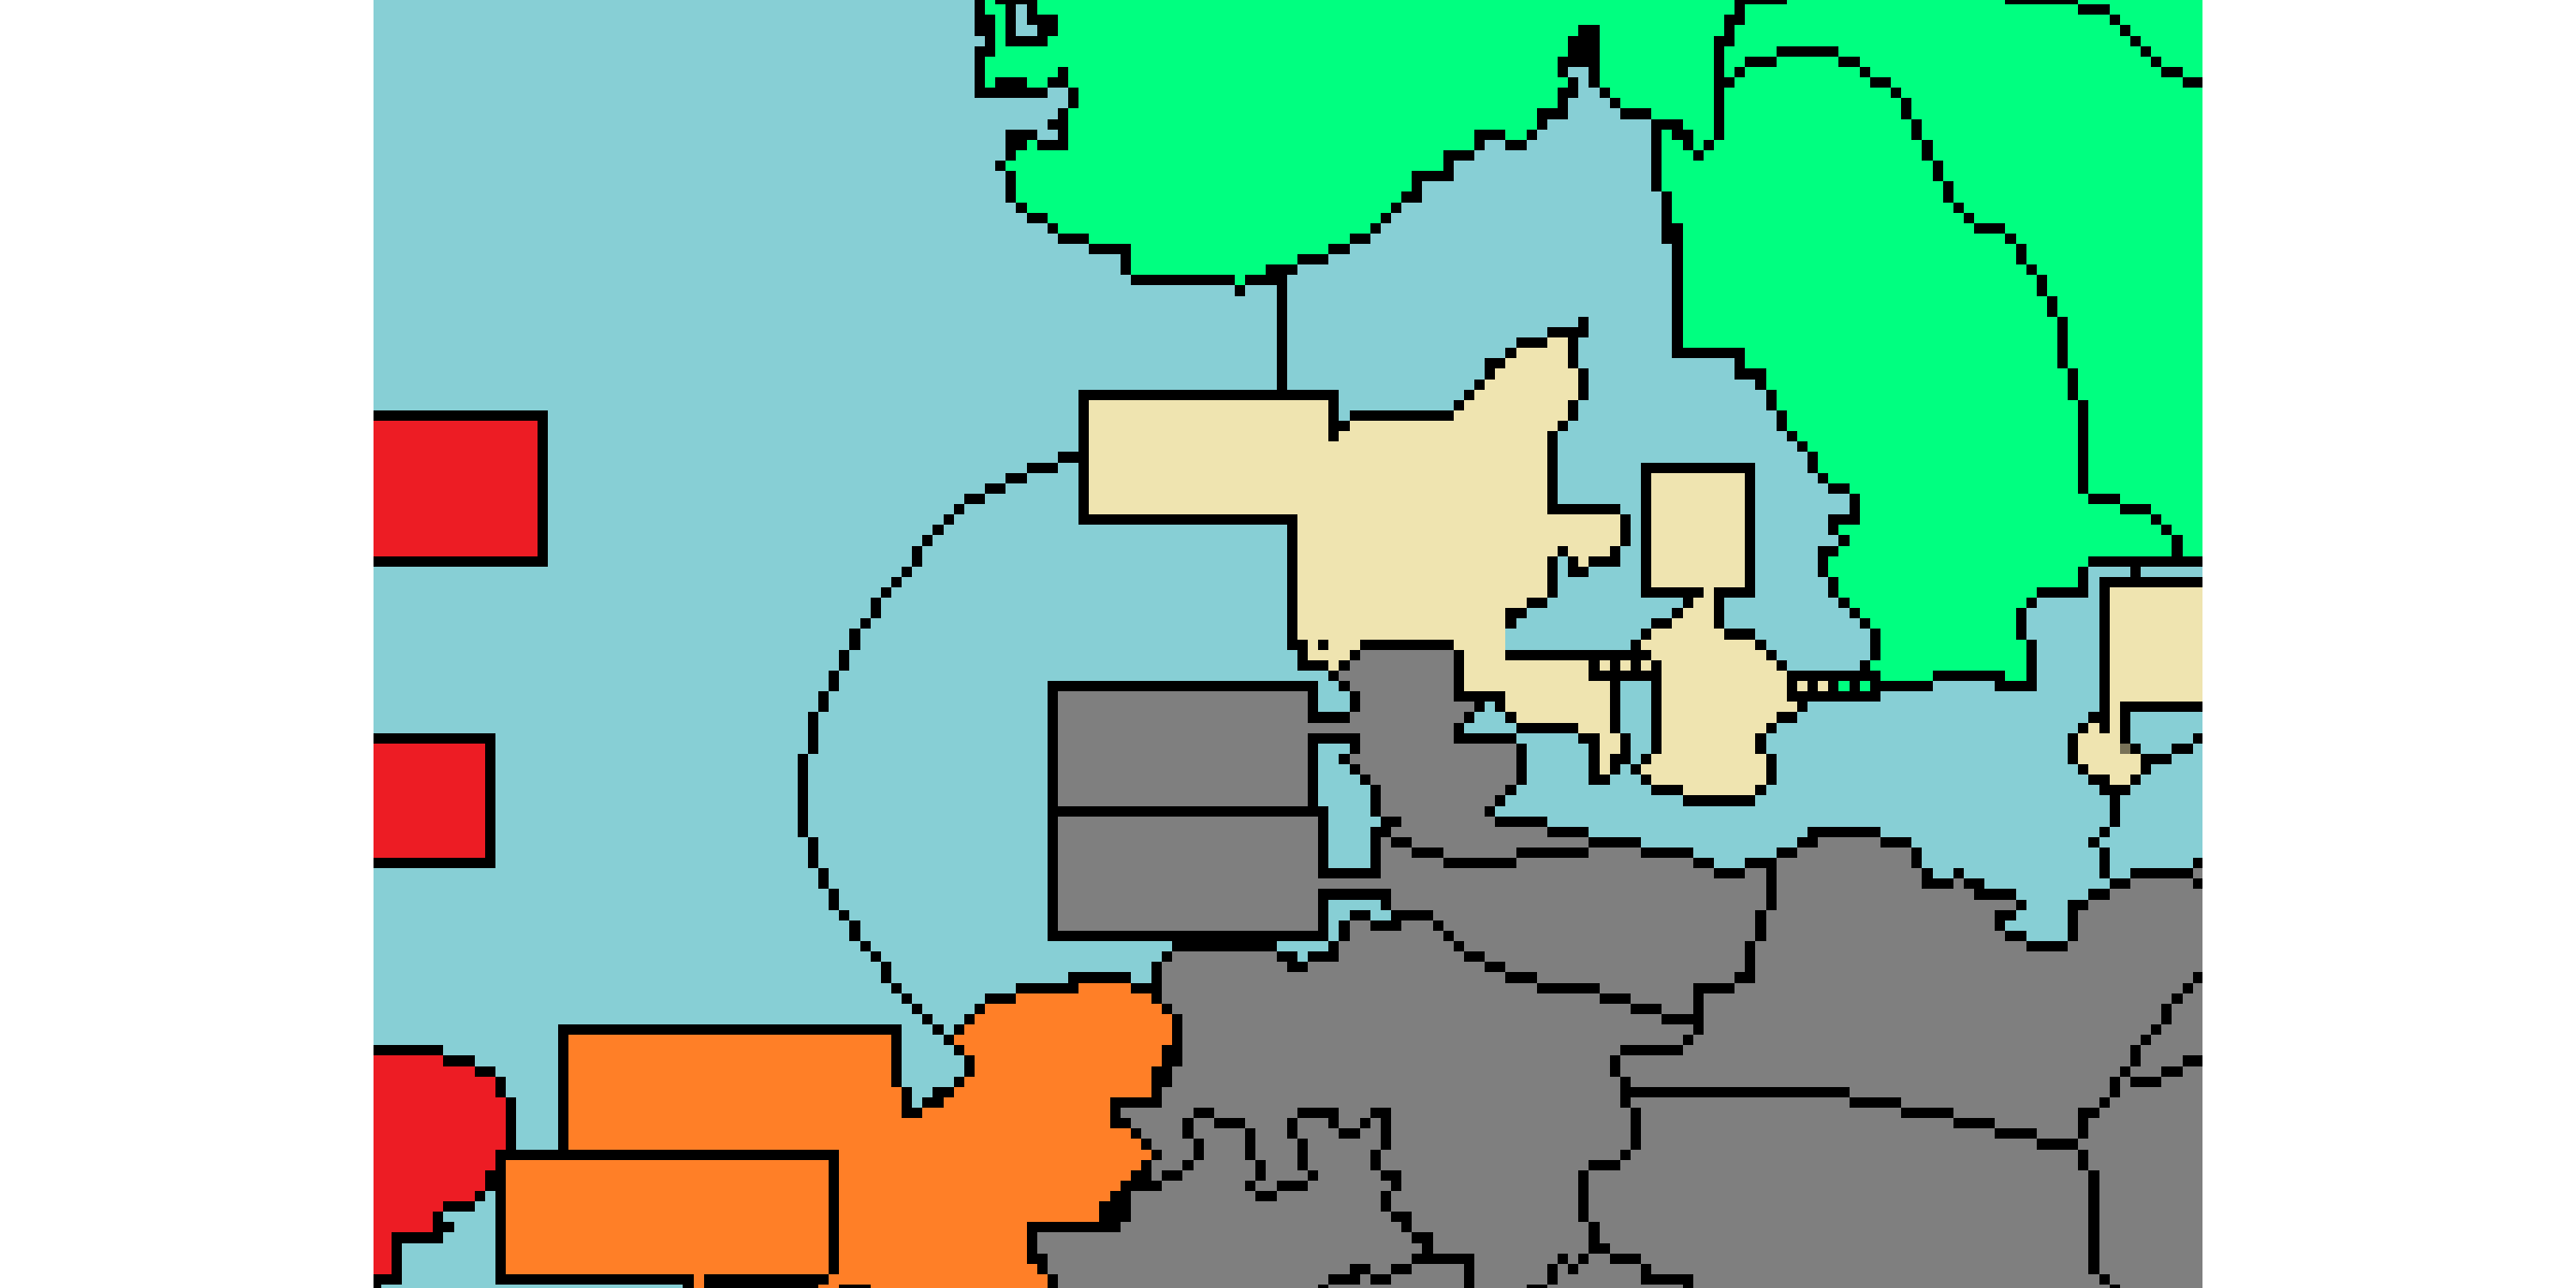

In [134]:
showx(rgb, regions)

In [135]:
# Image.fromarray(regions.astype(np.int16)).save(root / "regions.png")

In [131]:
# borders = find_boundaries(filled, mode='thick')
# showx(borders)

In [132]:
(img-regions).sum()

-4486665

In [106]:
img = np.array(Image.open(root/'regions.png'))
img.shape

(2232, 5988)

<IPython.core.display.Javascript object>


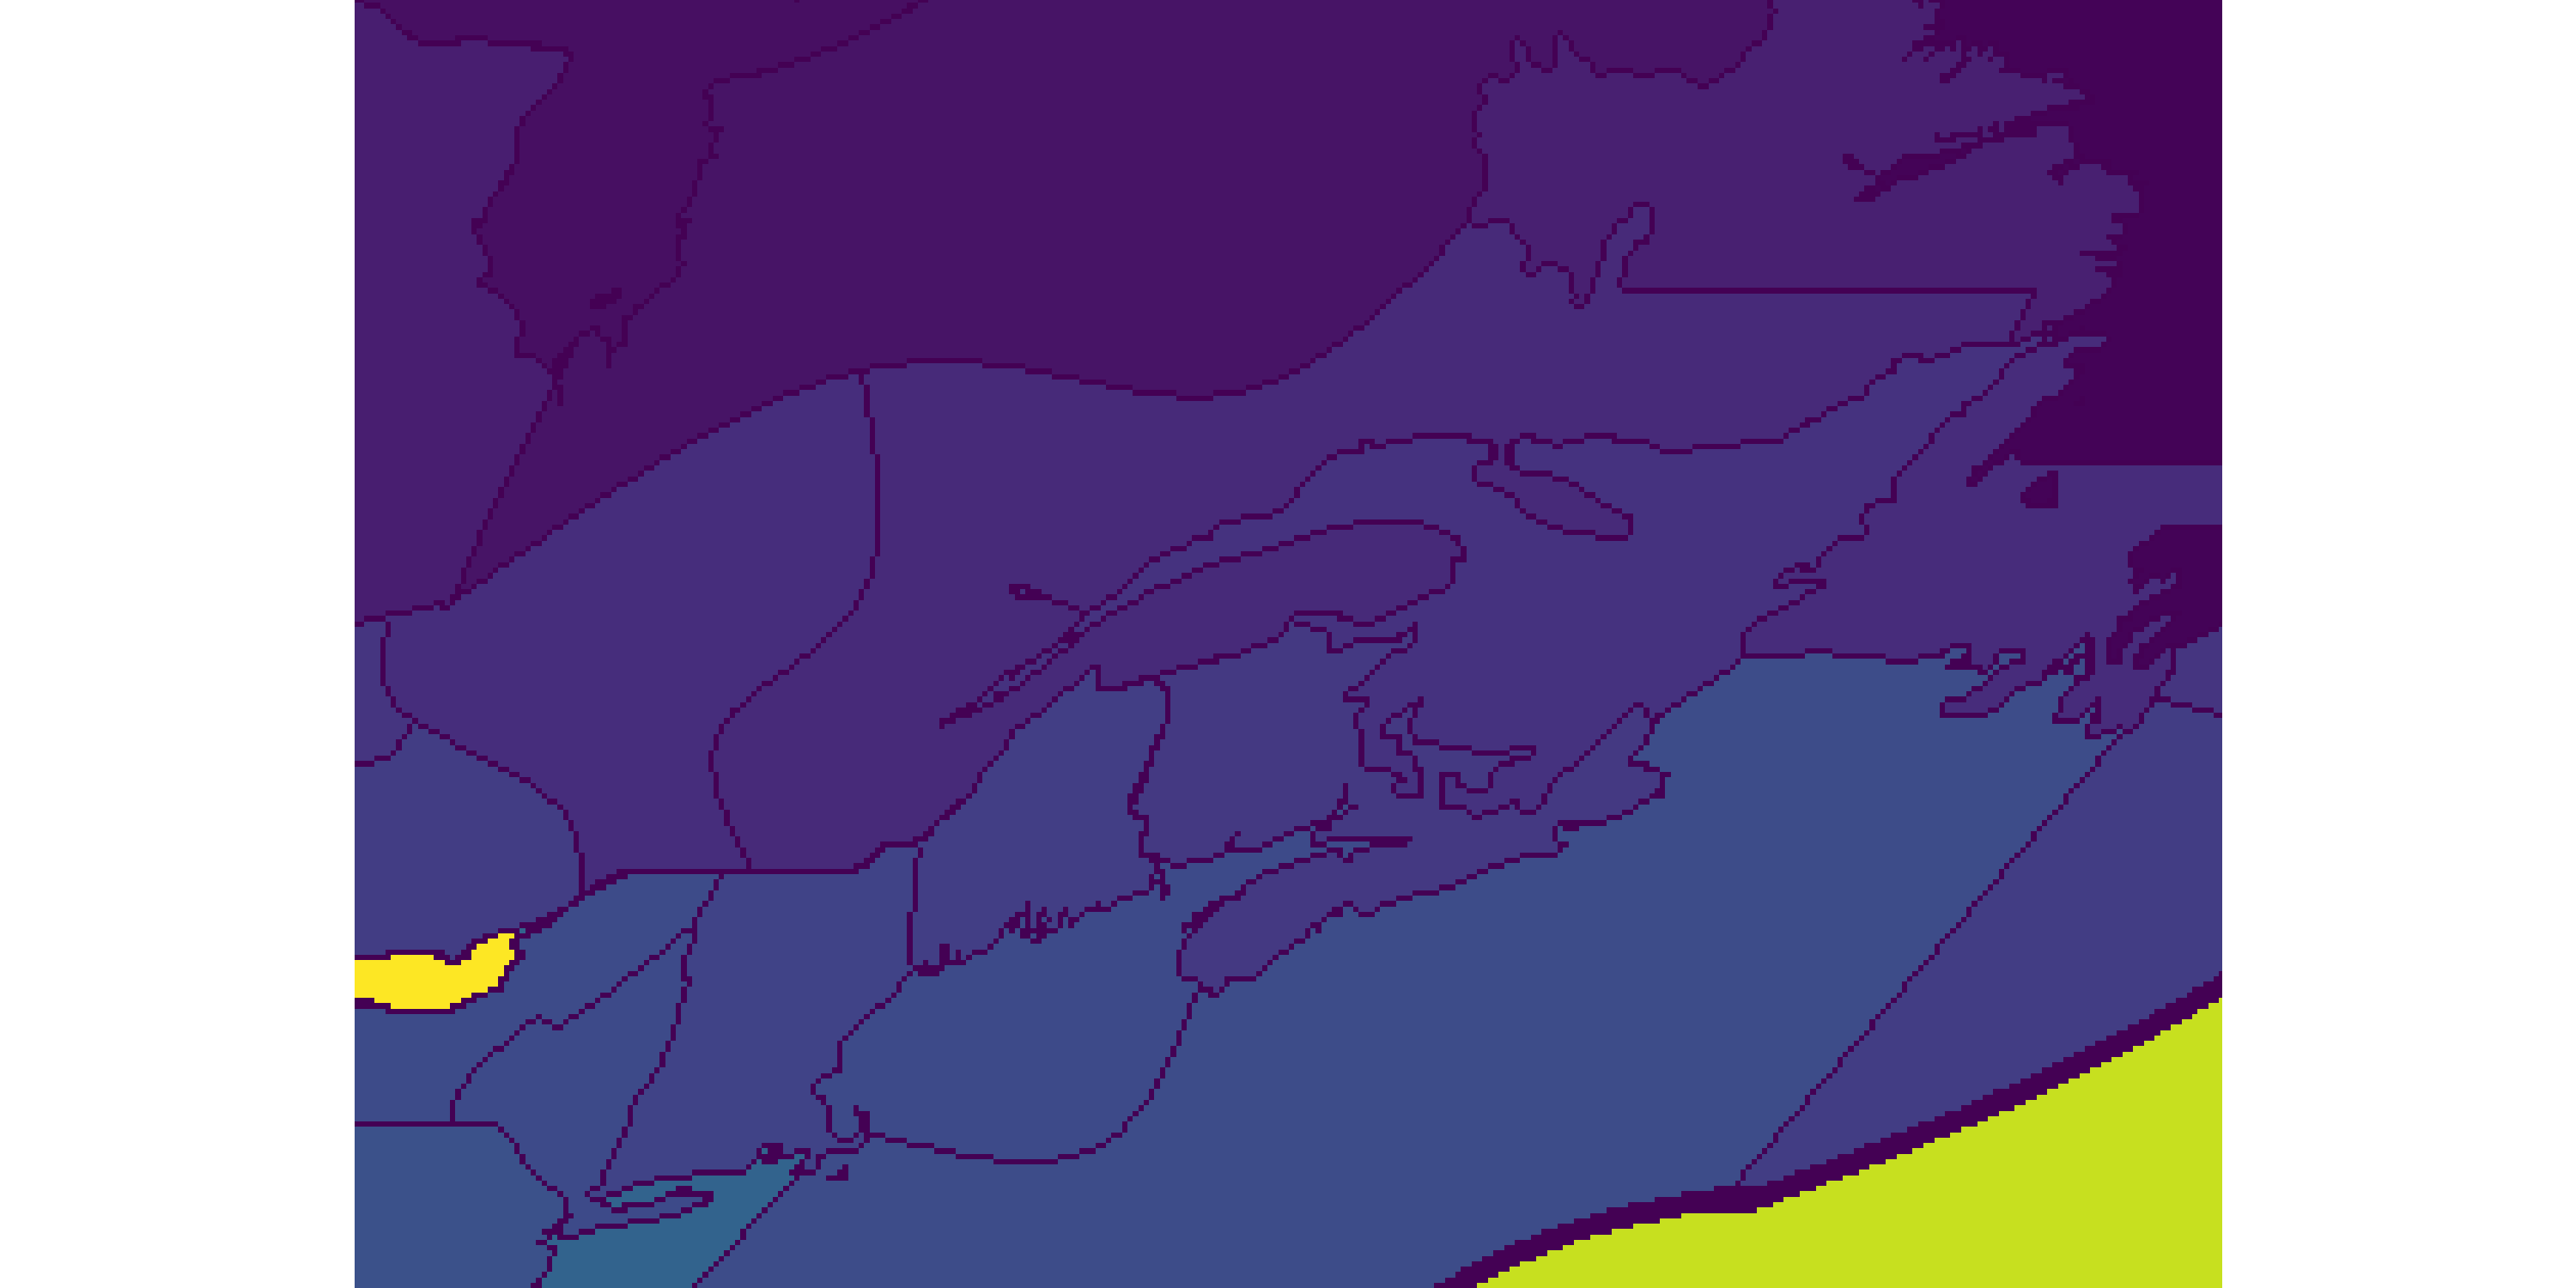

In [204]:
showx(img%1000,cover=None)

# Process Name List

In [220]:
from omnibelt import load_yaml, load_txt, save_yaml
from collections import OrderedDict

In [221]:
root

WindowsPath('extra/wd/step1')

In [222]:
raw = load_txt(root / '..' / 'full_names.txt').replace('.','').replace('\'','').split('\n')
names = OrderedDict(row.split(': ') for row in raw if len(row.strip()))
# names = {k:v for k,v in names.items()}
len(names)

741

In [228]:
'KHRKL' in fixed

False

In [ ]:
missing = 'ULUN', 'KAMI', 'SAFC',
unknown = 'MAPU',

In [244]:
missing = {i+1:f for i, f in enumerate(fixed) if f not in names and len(f)}
print(missing)

{92: 'KHRK', 94: 'BOH', 113: 'VIE', 121: 'KAMI', 654: 'SAFC', 666: 'ULUN'}


In [243]:
bad = [b for b in names if b not in fixed]
print(bad)

['BOHE', 'MAPU', 'VIEN', 'KHRKL']


In [246]:
# highlight(rgb, convex_mask(lbltiles[654]))

['BOHE', 'MAPU', 'VIEN', 'KHRKL']


In [219]:
# fixed

In [203]:
for m in missing:
    names[m] = ''

In [204]:
len(names)

748

In [208]:
save_yaml(dict(names), root/'node_names.yaml')

In [245]:
len(id2name)

724